# Eviction Forecasting

In [61]:
import pandas as pd
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point
from shapely.wkt import loads
from scipy.spatial import distance_matrix
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

## Data Processing

In [62]:
def load_parcels():
    df_p = (
        pd.read_csv("data/parcels.csv")
        .rename(columns=lambda x: x.strip().lower().replace(" ", "_"))
        .dropna(subset=["the_geom"])
    )#.sample(10_000)
    df_p["geometry"] = df_p["the_geom"].apply(loads)
    df_p = gpd.GeoDataFrame(df_p, geometry="geometry")
    return df_p

df_p = load_parcels()
df_p

/Users/gauravsett/Documents/GitHub/sf-eviction-forecasting/env/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()


closed_roll_year                     property_location parcel_number  \
95                   2011  0000 0000VBANCROFT            AV0000       4867021   
96                   2011  0000 0000 V                     0000       4957017   
97                   2011  0000 0000 V                     0000       4950003   
98                   2011  0000 0000VCARROLL             AV0000       4867012   
99                   2007  0000 0000 V                     0000       4890002   
...                   ...                                   ...           ...   
2666112              2019  0000 0423 RALSTON             ST0000       6996017   
2666113              2019  0000 0137 SAINT CHARLES       AV0000       7130015   
2666114              2019  0000 0115 LAKE MERCED         HL0000       7381054   
2666115              2019  0000 0002 BEACHMONT           DR0000       7221017   
2666116              2019  0000 0174 BRIGHT              ST0000       7115050   

        block  lot  volume_number use_code             use_definition  \
95       4867  021             29     MISC    Miscellaneous/Mixed-Use   
96       4957  017             30     MISC    Miscellaneous/Mixed-Use   
97       4950  003             30     MISC    Miscellaneous/Mixed-Use   
98       4867  012             29     MISC    Miscellaneous/Mixed-Use   
99       4890  002             30     MISC    Miscellaneous/Mixed-Use   
...       ...  ...            ...      ...                        ...   
2666112  6996  017             41     SRES  Single Family Residential   
2666113  7130  015             43     SRES  Single Family Residential   
2666114  7381  054             44     SRES  Single Family Residential   
2666115  7221  017             44     SRES  Single Family Residential   
2666116  7115  050             43     SRES  Single Family Residential   

        property_class_code property_class_code_definition  ...  \
95                        V                     Vacant Lot  ...   
96                        V                     Vacant Lot  ...   
97                        V                     Vacant Lot  ...   
98                        V                     Vacant Lot  ...   
99                        V                     Vacant Lot  ...   
...                     ...                            ...  ...   
2666112                   D                       Dwelling  ...   
2666113                   D                       Dwelling  ...   
2666114                   Z                    Condominium  ...   
2666115                   D                       Dwelling  ...   
2666116                   D                       Dwelling  ...   

         current_supervisor_districts_2  analysis_neighborhoods_2  \
95                                  NaN                       NaN   
96                                  NaN                       NaN   
97                                  NaN                       NaN   
98                                  NaN                       NaN   
99                                  NaN                       NaN   
...                                 ...                       ...   
2666112                             1.0                      24.0   
2666113                             8.0                      24.0   
2666114                             8.0                      16.0   
2666115                             8.0                      41.0   
2666116                             1.0                      24.0   

         delete_-_supervisor_districts_2  \
95                                   NaN   
96                                   NaN   
97                                   NaN   
98                                   NaN   
99                                   NaN   
...                                  ...   
2666112                              6.0   
2666113                              4.0   
2666114                              4.0   
2666115                              4.0   
2666116                              6.0 

In [63]:
def load_evictions():
    df_e = (
        pd.read_csv("data/evictions.csv")
        .rename(columns=lambda x: x.strip().lower().replace(" ", "_"))
        .dropna(subset=["shape"])
    )
    df_e["geometry"] = df_e["shape"].apply(loads)
    df_e["year"] = pd.to_datetime(df_e["file_date"]).dt.year.astype(int)
    df_e = gpd.GeoDataFrame(df_e, geometry="geometry")
    return df_e

df_e = load_evictions()
df_e

eviction_id                           address           city state  \
0          M222138         400 Block Of Eddy  Street  San Francisco    CA   
1          M211838         900 Block Of Bush  Street  San Francisco    CA   
2          M222033        1000 Block Of Pine  Street  San Francisco    CA   
3          M221840        100 Block Of Caine  Avenue  San Francisco    CA   
4          M120930   1900 Block Of Jefferson  Street  San Francisco    CA   
...            ...                               ...            ...   ...   
177573     M2K0482        2600 Block Of 36th  Avenue  San Francisco    CA   
177574     S000563  3500 Block Of Sacramento  Street  San Francisco    CA   
177575     S000649    1100 Block Of Chestnut  Street  San Francisco    CA   
177576     E991319  2100 Block Of Sacramento  Street  San Francisco    CA   
177577     E980910        0 Block Of Laussat  Street  San Francisco    CA   

        eviction_notice_source_zipcode   file_date  non_payment  breach  \
0                              94102.0  12/12/2022        False   False   
1                              94109.0  12/06/2021        False   False   
2                              94109.0  11/14/2022        False    True   
3                              94117.0  10/18/2022        False   False   
4                              94133.0  06/21/2012        False    True   
...                                ...         ...          ...     ...   
177573                         94116.0  03/24/2000        False   False   
177574                         94118.0  10/16/1997        False   False   
177575                             NaN  10/27/1997        False   False   
177576                         94115.0  07/12/1999        False   False   
177577                         94102.0  05/01/1998        False   False   

        nuisance  illegal_use  ...  delete_-_fire_prevention_districts  \
0           True        False  ...                                 NaN   
1           True        False  ...                                 NaN   
2          False        False  ...                                 NaN   
3          False        False  ...                                 NaN   
4          False        False  ...                                 NaN   
...          ...          ...  ...                                 ...   
177573     False        False  ...                                 1.0   
177574     False        False  ...                                11.0   
177575     False        False  ...                                 5.0   
177576     False        False  ...                                 NaN   
177577     False        False  ...                                 7.0   

        delete_-_zip_codes  cbd,_bid_and_gbd_boundaries_as_of_2017  \
0                      NaN                                     NaN   
1                      NaN                                     NaN   
2                      NaN                                     NaN   
3                      NaN                                     NaN   
4                      NaN                                     NaN   
...                    ...                                     ...   
177573             29491.0                                     NaN   
177574                54.0                                     NaN   
177575             28858.0                                     NaN   
177576                 NaN                                     NaN   
177577             28852.0                                     NaN   

        central_market/tenderloin_boundary  areas_of_vulnerability,_2016  \
0                                      NaN                           NaN   
1                                      NaN                           NaN   
2                                      NaN                           NaN   
3                                      NaN                           NaN   
4                                      NaN                           Na

In [64]:
def create_blocks(df_p):
    df_b = (
        df_p.loc[df_p["closed_roll_year"] == df_p["closed_roll_year"].max()]
        [["geometry", "block"]]
        .dropna()
        .drop_duplicates()
        .groupby("block")
        ["geometry"]
        .apply(lambda x: x.unary_union)
        .apply(lambda x: x.centroid)
        .reset_index()
    )
    return df_b

df_b = create_blocks(df_p)
df_b

block                     geometry
0     0001  POINT (-122.42156 37.80866)
1     0002  POINT (-122.42050 37.80873)
2     0004  POINT (-122.41508 37.80851)
3     0005  POINT (-122.41668 37.80840)
4     0006  POINT (-122.41835 37.80832)
...    ...                          ...
5397  8952  POINT (-122.36696 37.80978)
5398  8953  POINT (-122.36639 37.81007)
5399  8954  POINT (-122.36544 37.81144)
5400  8958  POINT (-122.36838 37.81103)
5401  9900  POINT (-122.39584 37.79294)

[5402 rows x 2 columns]

In [351]:
def merge_blocks_parcels(df_p, df_b):
    # Merge blocks onto parcels
    df = (
        df_p.merge(df_b, on="block", how="left")
        .rename(columns={"geometry_x": "geometry"})
        .dropna(subset=["geometry"])
    )
    df = gpd.GeoDataFrame(df, geometry="geometry")
    df = gpd.sjoin_nearest(df, df_b, how="left", max_distance=0.01)
    df["current_sales_date"] = (
        pd.to_datetime(df["current_sales_date"])
        .dt.year
        .fillna(-1)
        .astype(int)
    )
    # df["year_property_built"] = df["year_property_built"].fillna(-1).astype(int)
    return df

def aggregate_parcels(df):
    # Aggregate parcels by block and year
    mode = lambda x: x.value_counts().index[0]
    def by_year(df_y):
        return df_y.groupby("block_right").agg({
            "assessed_personal_property_value": "mean",
            "assessed_land_value": "mean",
            "assessed_fixtures_value": "mean",
            "assessed_improvement_value": "mean",
            "property_area": "mean",
            "number_of_units": "sum",
            "number_of_rooms": "mean",
            "number_of_bedrooms": "mean",
            "number_of_bathrooms": "mean",
            "use_code": list,
            # "zoning_code": list,
            # "property_class_code": list,
        })
    df = (
        df.groupby("closed_roll_year")
        .apply(by_year)
        .reset_index()
        .rename(columns={"block_right": "block", "closed_roll_year": "year"})
    )
    return df

def get_dummies(df, columns):
    for column in columns:
        d = pd.get_dummies(df[column].explode()).groupby(level=0).sum()
        d.columns = [f"{column}_{c.lower()}" for c in d.columns]
        df = df.drop(columns=[column]).merge(d, left_index=True, right_index=True)
    return df

def merge_evictions_blocks(df_e, df_b, df):
    # Merge evictions onto blocks
    df_e = gpd.sjoin_nearest(df_e, df_b, how="left", max_distance=0.001)
    df_e_agg = (
        df_e.groupby(["block", "year"])
        .size()
        .reset_index()
        .rename(columns={0: "eviction_count"})
    )
    def by_year(df_y):
        df_e_year = df_e_agg.loc[df_e_agg["year"] == df_y["year"].max()]
        return df_y.merge(df_e_year, how="left", on=["block"])
    df = df.groupby("year").apply(by_year).reset_index()
    df["eviction_count"] = df["eviction_count"].fillna(0).astype(int)
    df = df.drop(columns=["level_1", "year_x", "year_y"])
    df = df.sort_values(["year", "block"])
    return df

df = merge_blocks_parcels(df_p, df_b)
df = aggregate_parcels(df)
df = get_dummies(df, ["use_code"])
df = merge_evictions_blocks(df_e, df_b, df)
df.to_parquet("data/blocks.parquet")
df

KeyboardInterrupt: 

## Feature Engineering

In [352]:
df = pd.read_parquet("data/blocks.parquet")
df

year block  assessed_personal_property_value  assessed_land_value  \
0      2007  0001                               0.0                  0.0   
1      2007  0002                               0.0                  0.0   
2      2007  0004                               0.0                  0.0   
3      2007  0005                               0.0                  0.0   
4      2007  0006                               0.0                  0.0   
...     ...   ...                               ...                  ...   
69400  2019  8950                               0.0                  0.0   
69401  2019  8952                               0.0           13134600.0   
69402  2019  8953                               0.0                  0.0   
69403  2019  8954                               0.0            3090982.5   
69404  2019  8958                               0.0                  0.0   

       assessed_fixtures_value  assessed_improvement_value  property_area  \
0                          0.0                         0.0            0.0   
1                          0.0                         0.0            0.0   
2                          0.0                         0.0            0.0   
3                          0.0                         0.0            0.0   
4                          0.0                         0.0            0.0   
...                        ...                         ...            ...   
69400                      0.0                         0.0            0.0   
69401                      0.0                         0.0            0.0   
69402                      0.0                         0.0            0.0   
69403                      0.0                         0.0            0.0   
69404                      0.0                         0.0            0.0   

       number_of_units  number_of_rooms  number_of_bedrooms  ...  \
0                    0              0.0                 0.0  ...   
1                    0              0.0                 0.0  ...   
2                    0              0.0                 0.0  ...   
3                    0              0.0                 0.0  ...   
4                    0              0.0                 0.0  ...   
...                ...              ...                 ...  ...   
69400                0              0.0                 0.0  ...   
69401                0              0.0                 0.0  ...   
69402                0              0.0                 0.0  ...   
69403                0              0.0                 0.0  ...   
69404                0              0.0                 0.0  ...   

       use_code_comh  use_code_comm  use_code_como  use_code_comr  \
0                0.0            1.0            0.0            0.0   
1                0.0            1.0            0.0            0.0   
2                0.0            0.0            0.0            0.0   
3                0.0            1.0            0.0            0.0   
4                0.0            1.0            0.0            0.0   
...              ...            ...            ...            ...   
69400            0.0            0.0            0.0            0.0   
69401            0.0            0.0            0.0            0.0   
69402            0.0            0.0            0.0            0.0   
69403            0.0            0.0            0.0            0.0   
69404            0.0            0.0            0.0            0.0   

       use_code_govt  use_code_ind  use_code_misc  use_code_mres  \
0                1.0           0.0            1.0            0.0   
1                0.0           0.0            0.0            0.0   
2                1.0           0.0            1.0            0.0   
3                1.0           0.0            0.0            0.0   
4                3.0           0.0            0.0            0.0   
...              ...           ...            ...            ...   
69400            0.0           0.0            1

### Graph Construction

In [353]:
def build_graph(df_b):
    graph = nx.Graph()
    graph.add_nodes_from(df_b["block"])
    
    coordinates = [list(p.coords)[0] for p in df_b["geometry"]]
    matrix = distance_matrix(coordinates, coordinates)
    max_d = matrix.max()
    p = 0.02
    neighbors = np.argwhere(matrix < max_d*p)
    for i, j in tqdm(neighbors, total=len(neighbors)):
        if i < j:
            graph.add_edge(
                df_b.iloc[i]["block"], 
                df_b.iloc[j]["block"], 
                weight=matrix[i, j]
            )
    return graph

graph = build_graph(df_b)

100%|██████████| 115638/115638 [00:39<00:00, 2910.69it/s]


In [354]:
pd.Series([graph.degree(n) for n in graph.nodes]).describe()

count    5402.000000
mean       20.406516
std         6.689773
min         0.000000
25%        16.000000
50%        20.000000
75%        25.000000
max        53.000000
dtype: float64

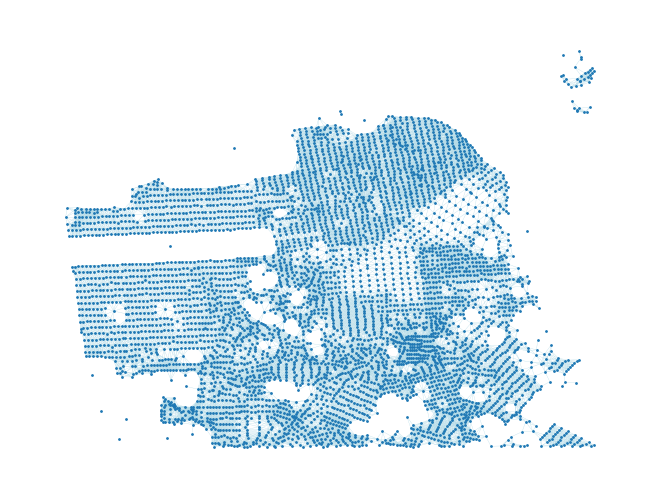

In [355]:
nx.draw(graph, pos={n: list(p.coords)[0] for n, p in df_b.set_index("block")["geometry"].items()}, edge_color="lightblue", node_size=1, width=0.2)

In [356]:
neighbors = df_b.apply(lambda x: [x["block"]] + list(graph.neighbors(x["block"])), axis=1).rename("neighbors")
neighbors.index = df_b["block"]
df["neighbors"] = pd.merge(df, neighbors, left_on="block", right_index=True, how="left")["neighbors"]
df["neighbors"]

0        [0001, 0002, 0006, 0007, 0010, 0024, 0025, 002...
1        [0002, 0001, 0006, 0007, 0010, 0011, 0023, 002...
2        [0004, 0005, 0006, 0011, 0012, 0013, 0014, 002...
3        [0005, 0004, 0006, 0007, 0010, 0011, 0012, 001...
4        [0006, 0001, 0002, 0004, 0005, 0007, 0010, 001...
                               ...                        
69400           [8950, 8947, 8948, 8949, 8952, 8953, 8958]
69401           [8952, 8948, 8949, 8950, 8953, 8954, 8958]
69402                 [8953, 8949, 8950, 8952, 8954, 8958]
69403                             [8954, 8952, 8953, 8958]
69404     [8958, 8947, 8948, 8949, 8950, 8952, 8953, 8954]
Name: neighbors, Length: 69405, dtype: object

### Spatial Aggregation

In [357]:
features = [c for c in df.columns if c not in ["block", "year", "geometry", "neighbors"]]
features

['assessed_personal_property_value',
 'assessed_land_value',
 'assessed_fixtures_value',
 'assessed_improvement_value',
 'property_area',
 'number_of_units',
 'number_of_rooms',
 'number_of_bedrooms',
 'number_of_bathrooms',
 'use_code_comh',
 'use_code_comm',
 'use_code_como',
 'use_code_comr',
 'use_code_govt',
 'use_code_ind',
 'use_code_misc',
 'use_code_mres',
 'use_code_sres',
 'eviction_count']

In [358]:
def compute_neighbor_features(df):
    def by_year(df_y):
        df_y = df_y["neighbors"].apply(
            lambda x: 
                df_y.loc[df_y["block"].isin(x)]
                [features]
                .dropna()
                .mean()
        )
        return df_y
    df = df.groupby("year").apply(by_year).reset_index(drop=True)
    return df

df_n = compute_neighbor_features(df)
df_n = df_n.rename(columns={c: f"{c}_neighbors" for c in df_n.columns})
df = df.merge(df_n, left_index=True, right_index=True)
df

year block  assessed_personal_property_value  assessed_land_value  \
0      2007  0001                               0.0                  0.0   
1      2007  0002                               0.0                  0.0   
2      2007  0004                               0.0                  0.0   
3      2007  0005                               0.0                  0.0   
4      2007  0006                               0.0                  0.0   
...     ...   ...                               ...                  ...   
69400  2019  8950                               0.0                  0.0   
69401  2019  8952                               0.0           13134600.0   
69402  2019  8953                               0.0                  0.0   
69403  2019  8954                               0.0            3090982.5   
69404  2019  8958                               0.0                  0.0   

       assessed_fixtures_value  assessed_improvement_value  property_area  \
0                          0.0                         0.0            0.0   
1                          0.0                         0.0            0.0   
2                          0.0                         0.0            0.0   
3                          0.0                         0.0            0.0   
4                          0.0                         0.0            0.0   
...                        ...                         ...            ...   
69400                      0.0                         0.0            0.0   
69401                      0.0                         0.0            0.0   
69402                      0.0                         0.0            0.0   
69403                      0.0                         0.0            0.0   
69404                      0.0                         0.0            0.0   

       number_of_units  number_of_rooms  number_of_bedrooms  ...  \
0                    0              0.0                 0.0  ...   
1                    0              0.0                 0.0  ...   
2                    0              0.0                 0.0  ...   
3                    0              0.0                 0.0  ...   
4                    0              0.0                 0.0  ...   
...                ...              ...                 ...  ...   
69400                0              0.0                 0.0  ...   
69401                0              0.0                 0.0  ...   
69402                0              0.0                 0.0  ...   
69403                0              0.0                 0.0  ...   
69404                0              0.0                 0.0  ...   

       use_code_comh_neighbors  use_code_comm_neighbors  \
0                     0.090909               123.454545   
1                     0.272727               123.454545   
2                     0.714286                 0.285714   
3                     0.866667                 0.333333   
4                     0.666667                 0.400000   
...                        ...                      ...   
69400                 0.000000                 0.000000   
69401                 0.000000                 0.000000   
69402                 0.000000                 0.000000   
69403                 0.000000                 0.000000   
69404                 0.000000                 0.000000   

       use_code_como_neighbors  use_code_comr_neighbors  \
0                     0.727273                 1.272727   
1                     0.818182                 1.272727   
2                     0.142857                 1.642857   
3                     0.200000                 1.400000   
4                     0.533333                 1.133333   
...                        ...                      ...   
69400                 0.000000                 0.000000   
69401                 0.000000                 0.000000   
69402                 0.000000                 0.000000   
69403                 0.000000                 0.0000

### Graph Features

In [359]:
df_g = df_b.copy()

In [360]:
def compute_degree(df_g):
    df_g["degree"] = df_g["block"].apply(lambda x: graph.degree(x))
    return df_g

df_g = compute_degree(df_g)
df_g

block                     geometry  degree
0     0001  POINT (-122.42156 37.80866)      10
1     0002  POINT (-122.42050 37.80873)      10
2     0004  POINT (-122.41508 37.80851)      13
3     0005  POINT (-122.41668 37.80840)      14
4     0006  POINT (-122.41835 37.80832)      14
...    ...                          ...     ...
5397  8952  POINT (-122.36696 37.80978)       6
5398  8953  POINT (-122.36639 37.81007)       5
5399  8954  POINT (-122.36544 37.81144)       3
5400  8958  POINT (-122.36838 37.81103)       7
5401  9900  POINT (-122.39584 37.79294)      22

[5402 rows x 3 columns]

In [361]:
def compute_clustering(df_g):
    df_g["clustering"] = nx.clustering(graph).values()
    return df_g

df_g = compute_clustering(df_g)
df_g

block                     geometry  degree  clustering
0     0001  POINT (-122.42156 37.80866)      10    0.800000
1     0002  POINT (-122.42050 37.80873)      10    0.844444
2     0004  POINT (-122.41508 37.80851)      13    0.743590
3     0005  POINT (-122.41668 37.80840)      14    0.670330
4     0006  POINT (-122.41835 37.80832)      14    0.681319
...    ...                          ...     ...         ...
5397  8952  POINT (-122.36696 37.80978)       6    0.733333
5398  8953  POINT (-122.36639 37.81007)       5    0.800000
5399  8954  POINT (-122.36544 37.81144)       3    1.000000
5400  8958  POINT (-122.36838 37.81103)       7    0.619048
5401  9900  POINT (-122.39584 37.79294)      22    0.584416

[5402 rows x 4 columns]

In [362]:
def compute_betweenness_centrality(df_g):
    df_g["betweenness_centrality"] = nx.betweenness_centrality(graph).values()
    return df_g

df_g = compute_betweenness_centrality(df_g)
df_g

block                     geometry  degree  clustering  \
0     0001  POINT (-122.42156 37.80866)      10    0.800000   
1     0002  POINT (-122.42050 37.80873)      10    0.844444   
2     0004  POINT (-122.41508 37.80851)      13    0.743590   
3     0005  POINT (-122.41668 37.80840)      14    0.670330   
4     0006  POINT (-122.41835 37.80832)      14    0.681319   
...    ...                          ...     ...         ...   
5397  8952  POINT (-122.36696 37.80978)       6    0.733333   
5398  8953  POINT (-122.36639 37.81007)       5    0.800000   
5399  8954  POINT (-122.36544 37.81144)       3    1.000000   
5400  8958  POINT (-122.36838 37.81103)       7    0.619048   
5401  9900  POINT (-122.39584 37.79294)      22    0.584416   

      betweenness_centrality  
0               1.791900e-06  
1               2.492843e-07  
2               1.340645e-05  
3               1.441052e-05  
4               9.709285e-06  
...                      ...  
5397            9.714708e-08  
5398            4.571627e-08  
5399            0.000000e+00  
5400            2.457250e-07  
5401            5.735262e-04  

[5402 rows x 5 columns]

In [363]:
def compute_closeness_centrality(df_g):
    df_g["closeness_centrality"] = nx.closeness_centrality(graph).values()
    return df_g

df_g = compute_closeness_centrality(df_g)
df_g

block                     geometry  degree  clustering  \
0     0001  POINT (-122.42156 37.80866)      10    0.800000   
1     0002  POINT (-122.42050 37.80873)      10    0.844444   
2     0004  POINT (-122.41508 37.80851)      13    0.743590   
3     0005  POINT (-122.41668 37.80840)      14    0.670330   
4     0006  POINT (-122.41835 37.80832)      14    0.681319   
...    ...                          ...     ...         ...   
5397  8952  POINT (-122.36696 37.80978)       6    0.733333   
5398  8953  POINT (-122.36639 37.81007)       5    0.800000   
5399  8954  POINT (-122.36544 37.81144)       3    1.000000   
5400  8958  POINT (-122.36838 37.81103)       7    0.619048   
5401  9900  POINT (-122.39584 37.79294)      22    0.584416   

      betweenness_centrality  closeness_centrality  
0               1.791900e-06              0.043991  
1               2.492843e-07              0.044009  
2               1.340645e-05              0.043313  
3               1.441052e-05              0.043642  
4               9.709285e-06              0.043866  
...                      ...                   ...  
5397            9.714708e-08              0.001134  
5398            4.571627e-08              0.001008  
5399            0.000000e+00              0.000825  
5400            2.457250e-07              0.001296  
5401            5.735262e-04              0.044910  

[5402 rows x 6 columns]

In [364]:
def compute_eigen_centrality(df_g):
    df_g["eigen_centrality"] = nx.eigenvector_centrality(graph).values()
    return df_g

df_g = compute_eigen_centrality(df_g)
df_g

block                     geometry  degree  clustering  \
0     0001  POINT (-122.42156 37.80866)      10    0.800000   
1     0002  POINT (-122.42050 37.80873)      10    0.844444   
2     0004  POINT (-122.41508 37.80851)      13    0.743590   
3     0005  POINT (-122.41668 37.80840)      14    0.670330   
4     0006  POINT (-122.41835 37.80832)      14    0.681319   
...    ...                          ...     ...         ...   
5397  8952  POINT (-122.36696 37.80978)       6    0.733333   
5398  8953  POINT (-122.36639 37.81007)       5    0.800000   
5399  8954  POINT (-122.36544 37.81144)       3    1.000000   
5400  8958  POINT (-122.36838 37.81103)       7    0.619048   
5401  9900  POINT (-122.39584 37.79294)      22    0.584416   

      betweenness_centrality  closeness_centrality  eigen_centrality  
0               1.791900e-06              0.043991      3.264575e-07  
1               2.492843e-07              0.044009      3.291674e-07  
2               1.340645e-05              0.043313      3.035517e-07  
3               1.441052e-05              0.043642      3.794351e-07  
4               9.709285e-06              0.043866      4.464551e-07  
...                      ...                   ...               ...  
5397            9.714708e-08              0.001134      8.721721e-24  
5398            4.571627e-08              0.001008      7.524343e-24  
5399            0.000000e+00              0.000825      4.871874e-24  
5400            2.457250e-07              0.001296      9.497001e-24  
5401            5.735262e-04              0.044910      2.885825e-07  

[5402 rows x 7 columns]

In [365]:
def compute_page_rank(df_g):
    df_g["page_rank"] = nx.pagerank(graph).values()
    return df_g

df_g = compute_page_rank(df_g)
df_g

block                     geometry  degree  clustering  \
0     0001  POINT (-122.42156 37.80866)      10    0.800000   
1     0002  POINT (-122.42050 37.80873)      10    0.844444   
2     0004  POINT (-122.41508 37.80851)      13    0.743590   
3     0005  POINT (-122.41668 37.80840)      14    0.670330   
4     0006  POINT (-122.41835 37.80832)      14    0.681319   
...    ...                          ...     ...         ...   
5397  8952  POINT (-122.36696 37.80978)       6    0.733333   
5398  8953  POINT (-122.36639 37.81007)       5    0.800000   
5399  8954  POINT (-122.36544 37.81144)       3    1.000000   
5400  8958  POINT (-122.36838 37.81103)       7    0.619048   
5401  9900  POINT (-122.39584 37.79294)      22    0.584416   

      betweenness_centrality  closeness_centrality  eigen_centrality  \
0               1.791900e-06              0.043991      3.264575e-07   
1               2.492843e-07              0.044009      3.291674e-07   
2               1.340645e-05              0.043313      3.035517e-07   
3               1.441052e-05              0.043642      3.794351e-07   
4               9.709285e-06              0.043866      4.464551e-07   
...                      ...                   ...               ...   
5397            9.714708e-08              0.001134      8.721721e-24   
5398            4.571627e-08              0.001008      7.524343e-24   
5399            0.000000e+00              0.000825      4.871874e-24   
5400            2.457250e-07              0.001296      9.497001e-24   
5401            5.735262e-04              0.044910      2.885825e-07   

      page_rank  
0      0.000108  
1      0.000100  
2      0.000127  
3      0.000137  
4      0.000135  
...         ...  
5397   0.000226  
5398   0.000185  
5399   0.000137  
5400   0.000250  
5401   0.000203  

[5402 rows x 8 columns]

In [366]:
def compute_bridges(df_g):
    bridges = pd.DataFrame(list(nx.bridges(graph)))
    bridges = pd.concat([bridges[0], bridges[1]]).drop_duplicates().reset_index(drop=True)
    df_g["bridge"] = df_g["block"].isin(bridges).astype(int)
    return df_g

df_g = compute_bridges(df_g)
df_g

block                     geometry  degree  clustering  \
0     0001  POINT (-122.42156 37.80866)      10    0.800000   
1     0002  POINT (-122.42050 37.80873)      10    0.844444   
2     0004  POINT (-122.41508 37.80851)      13    0.743590   
3     0005  POINT (-122.41668 37.80840)      14    0.670330   
4     0006  POINT (-122.41835 37.80832)      14    0.681319   
...    ...                          ...     ...         ...   
5397  8952  POINT (-122.36696 37.80978)       6    0.733333   
5398  8953  POINT (-122.36639 37.81007)       5    0.800000   
5399  8954  POINT (-122.36544 37.81144)       3    1.000000   
5400  8958  POINT (-122.36838 37.81103)       7    0.619048   
5401  9900  POINT (-122.39584 37.79294)      22    0.584416   

      betweenness_centrality  closeness_centrality  eigen_centrality  \
0               1.791900e-06              0.043991      3.264575e-07   
1               2.492843e-07              0.044009      3.291674e-07   
2               1.340645e-05              0.043313      3.035517e-07   
3               1.441052e-05              0.043642      3.794351e-07   
4               9.709285e-06              0.043866      4.464551e-07   
...                      ...                   ...               ...   
5397            9.714708e-08              0.001134      8.721721e-24   
5398            4.571627e-08              0.001008      7.524343e-24   
5399            0.000000e+00              0.000825      4.871874e-24   
5400            2.457250e-07              0.001296      9.497001e-24   
5401            5.735262e-04              0.044910      2.885825e-07   

      page_rank  bridge  
0      0.000108       0  
1      0.000100       0  
2      0.000127       0  
3      0.000137       0  
4      0.000135       0  
...         ...     ...  
5397   0.000226       0  
5398   0.000185       0  
5399   0.000137       0  
5400   0.000250       0  
5401   0.000203       0  

[5402 rows x 9 columns]

In [367]:
def compute_cliques(df_g):
    df_g["cliques"] = nx.node_clique_number(graph).values()
    return df_g

df_g = compute_cliques(df_g)
df_g

block                     geometry  degree  clustering  \
0     0001  POINT (-122.42156 37.80866)      10    0.800000   
1     0002  POINT (-122.42050 37.80873)      10    0.844444   
2     0004  POINT (-122.41508 37.80851)      13    0.743590   
3     0005  POINT (-122.41668 37.80840)      14    0.670330   
4     0006  POINT (-122.41835 37.80832)      14    0.681319   
...    ...                          ...     ...         ...   
5397  8952  POINT (-122.36696 37.80978)       6    0.733333   
5398  8953  POINT (-122.36639 37.81007)       5    0.800000   
5399  8954  POINT (-122.36544 37.81144)       3    1.000000   
5400  8958  POINT (-122.36838 37.81103)       7    0.619048   
5401  9900  POINT (-122.39584 37.79294)      22    0.584416   

      betweenness_centrality  closeness_centrality  eigen_centrality  \
0               1.791900e-06              0.043991      3.264575e-07   
1               2.492843e-07              0.044009      3.291674e-07   
2               1.340645e-05              0.043313      3.035517e-07   
3               1.441052e-05              0.043642      3.794351e-07   
4               9.709285e-06              0.043866      4.464551e-07   
...                      ...                   ...               ...   
5397            9.714708e-08              0.001134      8.721721e-24   
5398            4.571627e-08              0.001008      7.524343e-24   
5399            0.000000e+00              0.000825      4.871874e-24   
5400            2.457250e-07              0.001296      9.497001e-24   
5401            5.735262e-04              0.044910      2.885825e-07   

      page_rank  bridge  cliques  
0      0.000108       0        8  
1      0.000100       0        8  
2      0.000127       0        8  
3      0.000137       0        8  
4      0.000135       0        8  
...         ...     ...      ...  
5397   0.000226       0        5  
5398   0.000185       0        5  
5399   0.000137       0        4  
5400   0.000250       0        5  
5401   0.000203       0       10  

[5402 rows x 10 columns]

In [368]:
def compute_constraint(df_g):
    df_g["constraint"] = nx.constraint(graph).values()
    return df_g

df_g = compute_constraint(df_g)
df_g

block                     geometry  degree  clustering  \
0     0001  POINT (-122.42156 37.80866)      10    0.800000   
1     0002  POINT (-122.42050 37.80873)      10    0.844444   
2     0004  POINT (-122.41508 37.80851)      13    0.743590   
3     0005  POINT (-122.41668 37.80840)      14    0.670330   
4     0006  POINT (-122.41835 37.80832)      14    0.681319   
...    ...                          ...     ...         ...   
5397  8952  POINT (-122.36696 37.80978)       6    0.733333   
5398  8953  POINT (-122.36639 37.81007)       5    0.800000   
5399  8954  POINT (-122.36544 37.81144)       3    1.000000   
5400  8958  POINT (-122.36838 37.81103)       7    0.619048   
5401  9900  POINT (-122.39584 37.79294)      22    0.584416   

      betweenness_centrality  closeness_centrality  eigen_centrality  \
0               1.791900e-06              0.043991      3.264575e-07   
1               2.492843e-07              0.044009      3.291674e-07   
2               1.340645e-05              0.043313      3.035517e-07   
3               1.441052e-05              0.043642      3.794351e-07   
4               9.709285e-06              0.043866      4.464551e-07   
...                      ...                   ...               ...   
5397            9.714708e-08              0.001134      8.721721e-24   
5398            4.571627e-08              0.001008      7.524343e-24   
5399            0.000000e+00              0.000825      4.871874e-24   
5400            2.457250e-07              0.001296      9.497001e-24   
5401            5.735262e-04              0.044910      2.885825e-07   

      page_rank  bridge  cliques  constraint  
0      0.000108       0        8    0.205829  
1      0.000100       0        8    0.207862  
2      0.000127       0        8    0.170369  
3      0.000137       0        8    0.157117  
4      0.000135       0        8    0.159815  
...         ...     ...      ...         ...  
5397   0.000226       0        5    0.495780  
5398   0.000185       0        5    0.522129  
5399   0.000137       0        4    0.598433  
5400   0.000250       0        5    0.459773  
5401   0.000203       0       10    0.118661  

[5402 rows x 11 columns]

In [369]:
df = df.merge(df_g, on="block")
df

year block  assessed_personal_property_value  assessed_land_value  \
0      2007  0001                               0.0                  0.0   
1      2008  0001                               0.0                  0.0   
2      2009  0001                               0.0                  0.0   
3      2010  0001                               0.0                  0.0   
4      2011  0001                               0.0                  0.0   
...     ...   ...                               ...                  ...   
69400  2019  8935                               0.0                  0.0   
69401  2019  8939                               0.0                  0.0   
69402  2019  8941                               0.0                  0.0   
69403  2019  8942                               0.0                  0.0   
69404  2019  8943                               0.0                  0.0   

       assessed_fixtures_value  assessed_improvement_value  property_area  \
0                          0.0                         0.0            0.0   
1                          0.0                         0.0            0.0   
2                          0.0                         0.0            0.0   
3                          0.0                         0.0            0.0   
4                          0.0                         0.0            0.0   
...                        ...                         ...            ...   
69400                      0.0                         0.0            0.0   
69401                      0.0                         0.0            0.0   
69402                      0.0                         0.0            0.0   
69403                      0.0                         0.0            0.0   
69404                      0.0                         0.0            0.0   

       number_of_units  number_of_rooms  number_of_bedrooms  ...  \
0                    0              0.0                 0.0  ...   
1                    0              0.0                 0.0  ...   
2                    0              0.0                 0.0  ...   
3                    0              0.0                 0.0  ...   
4                    0              0.0                 0.0  ...   
...                ...              ...                 ...  ...   
69400                0              0.0                 0.0  ...   
69401                0              0.0                 0.0  ...   
69402                0              0.0                 0.0  ...   
69403                0              0.0                 0.0  ...   
69404                0              0.0                 0.0  ...   

                          geometry  degree  clustering  \
0      POINT (-122.42156 37.80866)      10    0.800000   
1      POINT (-122.42156 37.80866)      10    0.800000   
2      POINT (-122.42156 37.80866)      10    0.800000   
3      POINT (-122.42156 37.80866)      10    0.800000   
4      POINT (-122.42156 37.80866)      10    0.800000   
...                            ...     ...         ...   
69400  POINT (-122.36698 37.81994)      14    0.736264   
69401  POINT (-122.36542 37.82124)      13    0.794872   
69402  POINT (-122.36477 37.82179)      11    0.872727   
69403  POINT (-122.36546 37.82272)      10    0.911111   
69404  POINT (-122.36418 37.82240)       8    1.000000   

       betweenness_centrality  closeness_centrality  eigen_centrality  \
0                1.791900e-06              0.043991      3.264575e-07   
1                1.791900e-06              0.043991      3.264575e-07   
2                1.791900e-06              0.043991      3.264575e-07   
3                1.791900e-06              0.043991      3.264575e-07   
4                1.791900e-06              0.043991      3.264575e-07   
...                       ...                   ...               ...   
69400            6.427825e-07              0.002721      3.270568e-15   
69401            3.523019e-07              0.002608      3.085459e-15  

In [370]:
df["latitude"] = df["geometry"].apply(lambda x: x.centroid.y)
df["longitude"] = df["geometry"].apply(lambda x: x.centroid.x)

In [371]:
df.drop(columns=["geometry"]).to_parquet("data/input.parquet")

## Model Training

### Data Preparation

In [372]:
df = pd.read_parquet("data/input.parquet")
df

year block  assessed_personal_property_value  assessed_land_value  \
0      2007  0001                               0.0                  0.0   
1      2008  0001                               0.0                  0.0   
2      2009  0001                               0.0                  0.0   
3      2010  0001                               0.0                  0.0   
4      2011  0001                               0.0                  0.0   
...     ...   ...                               ...                  ...   
69400  2019  8935                               0.0                  0.0   
69401  2019  8939                               0.0                  0.0   
69402  2019  8941                               0.0                  0.0   
69403  2019  8942                               0.0                  0.0   
69404  2019  8943                               0.0                  0.0   

       assessed_fixtures_value  assessed_improvement_value  property_area  \
0                          0.0                         0.0            0.0   
1                          0.0                         0.0            0.0   
2                          0.0                         0.0            0.0   
3                          0.0                         0.0            0.0   
4                          0.0                         0.0            0.0   
...                        ...                         ...            ...   
69400                      0.0                         0.0            0.0   
69401                      0.0                         0.0            0.0   
69402                      0.0                         0.0            0.0   
69403                      0.0                         0.0            0.0   
69404                      0.0                         0.0            0.0   

       number_of_units  number_of_rooms  number_of_bedrooms  ...  clustering  \
0                    0              0.0                 0.0  ...    0.800000   
1                    0              0.0                 0.0  ...    0.800000   
2                    0              0.0                 0.0  ...    0.800000   
3                    0              0.0                 0.0  ...    0.800000   
4                    0              0.0                 0.0  ...    0.800000   
...                ...              ...                 ...  ...         ...   
69400                0              0.0                 0.0  ...    0.736264   
69401                0              0.0                 0.0  ...    0.794872   
69402                0              0.0                 0.0  ...    0.872727   
69403                0              0.0                 0.0  ...    0.911111   
69404                0              0.0                 0.0  ...    1.000000   

       betweenness_centrality  closeness_centrality  eigen_centrality  \
0                1.791900e-06              0.043991      3.264575e-07   
1                1.791900e-06              0.043991      3.264575e-07   
2                1.791900e-06              0.043991      3.264575e-07   
3                1.791900e-06              0.043991      3.264575e-07   
4                1.791900e-06              0.043991      3.264575e-07   
...                       ...                   ...               ...   
69400            6.427825e-07              0.002721      3.270568e-15   
69401            3.523019e-07              0.002608      3.085459e-15   
69402            8.077448e-08              0.002276      2.641854e-15   
69403            4.934455e-08              0.002235      2.414316e-15   
69404            0.000000e+00              0.002121      1.908422e-15   

       page_rank  bridge  cliques  constraint   latitude   longitude  
0       0.000108       0        8    0.205829  37.808658 -122.421557  
1       0.000108       0        8    0.205829  37.808658 -122.421557  
2       0.000108       0        8    0.205829  37.808658 -122.421557  
3       0.000108       0        8    0.205829  

In [373]:
df = df.dropna().groupby("block").filter(lambda x: len(x) == 13)
df

year block  assessed_personal_property_value  assessed_land_value  \
0      2007  0001                               0.0                  0.0   
1      2008  0001                               0.0                  0.0   
2      2009  0001                               0.0                  0.0   
3      2010  0001                               0.0                  0.0   
4      2011  0001                               0.0                  0.0   
...     ...   ...                               ...                  ...   
69308  2015  8953                               0.0                  0.0   
69309  2016  8953                               0.0                  0.0   
69310  2017  8953                               0.0                  0.0   
69311  2018  8953                               0.0                  0.0   
69312  2019  8953                               0.0                  0.0   

       assessed_fixtures_value  assessed_improvement_value  property_area  \
0                          0.0                         0.0            0.0   
1                          0.0                         0.0            0.0   
2                          0.0                         0.0            0.0   
3                          0.0                         0.0            0.0   
4                          0.0                         0.0            0.0   
...                        ...                         ...            ...   
69308                      0.0                         0.0            0.0   
69309                      0.0                         0.0            0.0   
69310                      0.0                         0.0            0.0   
69311                      0.0                         0.0            0.0   
69312                      0.0                         0.0            0.0   

       number_of_units  number_of_rooms  number_of_bedrooms  ...  clustering  \
0                    0              0.0                 0.0  ...         0.8   
1                    0              0.0                 0.0  ...         0.8   
2                    0              0.0                 0.0  ...         0.8   
3                    0              0.0                 0.0  ...         0.8   
4                    0              0.0                 0.0  ...         0.8   
...                ...              ...                 ...  ...         ...   
69308                0              0.0                 0.0  ...         0.8   
69309                0              0.0                 0.0  ...         0.8   
69310                0              0.0                 0.0  ...         0.8   
69311                0              0.0                 0.0  ...         0.8   
69312                0              0.0                 0.0  ...         0.8   

       betweenness_centrality  closeness_centrality  eigen_centrality  \
0                1.791900e-06              0.043991      3.264575e-07   
1                1.791900e-06              0.043991      3.264575e-07   
2                1.791900e-06              0.043991      3.264575e-07   
3                1.791900e-06              0.043991      3.264575e-07   
4                1.791900e-06              0.043991      3.264575e-07   
...                       ...                   ...               ...   
69308            4.571627e-08              0.001008      7.524343e-24   
69309            4.571627e-08              0.001008      7.524343e-24   
69310            4.571627e-08              0.001008      7.524343e-24   
69311            4.571627e-08              0.001008      7.524343e-24   
69312            4.571627e-08              0.001008      7.524343e-24   

       page_rank  bridge  cliques  constraint   latitude   longitude  
0       0.000108       0        8    0.205829  37.808658 -122.421557  
1       0.000108       0        8    0.205829  37.808658 -122.421557  
2       0.000108       0        8    0.205829  37.808658 -122.421557  
3       0.000108       0        8    0.205829  

In [374]:
features_s = features + [f"{f}_neighbors" for f in features]

def standardize(df):
    def by_year(df_y):
        df_y[features_s] = df_y[features_s].apply(lambda x: (x - x.mean()) / x.std())
        return df_y
    df = df.groupby("year").apply(by_year).reset_index(drop=True)
    return df

df = standardize(df)
df

year block  assessed_personal_property_value  assessed_land_value  \
0      2007  0001                         -0.048736            -0.153240   
1      2008  0001                         -0.046255            -0.160072   
2      2009  0001                         -0.047407            -0.164733   
3      2010  0001                         -0.042498            -0.148226   
4      2011  0001                         -0.040306            -0.151999   
...     ...   ...                               ...                  ...   
65476  2015  8953                         -0.037972            -0.163313   
65477  2016  8953                         -0.051237            -0.117633   
65478  2017  8953                         -0.049861            -0.123975   
65479  2018  8953                         -0.055504            -0.130231   
65480  2019  8953                         -0.055988            -0.136049   

       assessed_fixtures_value  assessed_improvement_value  property_area  \
0                    -0.024015                   -0.125269      -0.166982   
1                    -0.021660                   -0.122788      -0.166307   
2                    -0.021875                   -0.123399      -0.166179   
3                    -0.025029                   -0.131400      -0.166213   
4                    -0.031167                   -0.122098      -0.165368   
...                        ...                         ...            ...   
65476                -0.049041                   -0.125213      -0.167579   
65477                -0.040280                   -0.121556      -0.168813   
65478                -0.039982                   -0.127037      -0.168898   
65479                -0.038447                   -0.126966      -0.172049   
65480                -0.041364                   -0.079773      -0.169392   

       number_of_units  number_of_rooms  number_of_bedrooms  ...  clustering  \
0            -0.545993        -0.261364           -0.192775  ...         0.8   
1            -0.553512        -0.277003           -0.205985  ...         0.8   
2            -0.553273        -0.276147           -0.211944  ...         0.8   
3            -0.553574        -0.275697           -0.217999  ...         0.8   
4            -0.549922        -0.276427           -0.206667  ...         0.8   
...                ...              ...                 ...  ...         ...   
65476        -0.547264        -0.275243           -0.262655  ...         0.8   
65477        -0.543937        -0.252271           -0.269763  ...         0.8   
65478        -0.557436        -0.251848           -0.269857  ...         0.8   
65479        -0.540508        -0.250367           -0.296662  ...         0.8   
65480        -0.536231        -0.249664           -0.239202  ...         0.8   

       betweenness_centrality  closeness_centrality  eigen_centrality  \
0                1.791900e-06              0.043991      3.264575e-07   
1                1.791900e-06              0.043991      3.264575e-07   
2                1.791900e-06              0.043991      3.264575e-07   
3                1.791900e-06              0.043991      3.264575e-07   
4                1.791900e-06              0.043991      3.264575e-07   
...                       ...                   ...               ...   
65476            4.571627e-08              0.001008      7.524343e-24   
65477            4.571627e-08              0.001008      7.524343e-24   
65478            4.571627e-08              0.001008      7.524343e-24   
65479            4.571627e-08              0.001008      7.524343e-24   
65480            4.571627e-08              0.001008      7.524343e-24   

       page_rank  bridge  cliques  constraint   latitude   longitude  
0       0.000108       0        8    0.205829  37.808658 -122.421557  
1       0.000108       0        8    0.205829  37.808658 -122.421557  
2       0.000108       0        8    0.205829  37.808658 -122.421557  
3       0.000108       0        8    0.205829  

In [375]:
[c for c in df.columns if "itude" in c]

['latitude', 'longitude']

In [376]:
feature_sets = {
    "tax": [f for f in features if "itude" not in f],
    "neighbor": [f"{f}_neighbors" for f in features if "itude" not in f],
    "graph": ["degree", "clustering", "betweenness_centrality", "closeness_centrality", "eigen_centrality", "page_rank", "bridge", "cliques", "constraint", "longitude", "latitude"],
}

feature_sets["all"] = list(set(feature_sets["tax"] + feature_sets["neighbor"] + feature_sets["graph"] + [c for c in df.columns if "use_code" in c]))

In [377]:
df["eviction_class"] = df["eviction_count"].apply(lambda x: 1 if x > 0 else 0)

### Autoregressive Model

In [378]:
import sklearn
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from copy import deepcopy

In [379]:
def train_autoregressive_classifier(data, features):
    df_x = data[features + ["year"]]
    df_y = data[["year", "eviction_class"]]
    model = xgb.XGBClassifier(
        max_depth=10, n_estimators=100, learning_rate=0.05, random_state=7,
    )
    params = model.get_xgb_params()
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    kf = KFold(n_splits=5, shuffle=True, random_state=7)
    for year in range(2007, 2019):
        x = df_x.loc[df_x["year"] == year].drop(columns=["year"]).values
        y = df_y.loc[df_y["year"] == year+1].drop(columns=["year"]).values
        accuracy_kf = []
        precision_kf = []
        recall_kf = []
        f1_kf = []
        for train_index, test_index in kf.split(x):
            model_k = deepcopy(model)
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]
            if year == 2007:
                model_k.fit(x_train, y_train)
                y_pred = model_k.predict(x_test)
            else:
                d = xgb.DMatrix(x_train, label=y_train)
                model_k = xgb.train(params, d)
                y_pred = model_k.predict(xgb.DMatrix(x_test))
            y_pred = np.where(y_pred > 0.5, 1, 0)
            accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
            precision = sklearn.metrics.precision_score(y_test, y_pred)
            recall = sklearn.metrics.recall_score(y_test, y_pred)
            f1 = sklearn.metrics.f1_score(y_test, y_pred)
            accuracy_kf.append(accuracy)
            precision_kf.append(precision)
            recall_kf.append(recall)
            f1_kf.append(f1)
        model = model_k
        accuracy = np.mean(accuracy_kf)
        accuracy_std = np.std(accuracy_kf)
        print(f"Year {year} Accuracy: {accuracy} +/- {accuracy_std}")
        accuracies.append(accuracy)
        precision = np.mean(precision_kf)
        precision_std = np.std(precision_kf)
        # print(f"Year {year} Precision: {precision} +/- {precision_std}")
        precisions.append(precision)
        recall = np.mean(recall_kf)
        recall_std = np.std(recall_kf)
        # print(f"Year {year} Recall: {recall} +/- {recall_std}")
        recalls.append(recall)
        f1 = np.mean(f1_kf)
        f1_std = np.std(f1_kf)
        # print(f"Year {year} F1: {f1} +/- {f1_std}")
        f1s.append(f1)
    return model, (accuracies, precisions, recalls, f1s)

In [407]:
model, metrics = train_autoregressive_classifier(df, feature_sets["all"])
[m[-1].round(4) for m in metrics]

Year 2007 Accuracy: 0.8683727794328588 +/- 0.0094071943617392
Year 2008 Accuracy: 0.8856461121356851 +/- 0.00812689074962067
Year 2009 Accuracy: 0.8820725161961509 +/- 0.010513502482738314
Year 2010 Accuracy: 0.8749245361832253 +/- 0.003746384339547707
Year 2011 Accuracy: 0.8411750681735786 +/- 0.004492829634180205
Year 2012 Accuracy: 0.8312487192824829 +/- 0.004259667960988608
Year 2013 Accuracy: 0.8104017906401223 +/- 0.010908967655969123
Year 2014 Accuracy: 0.7957088081839819 +/- 0.013911468866450238
Year 2015 Accuracy: 0.8235049100739269 +/- 0.01849624114621625
Year 2016 Accuracy: 0.8560627196923125 +/- 0.007368617061777521
Year 2017 Accuracy: 0.8479270109235353 +/- 0.013957223935195627
Year 2018 Accuracy: 0.883262007219306 +/- 0.007259160185348252


[0.8833, 0.458, 0.1096, 0.176]

In [408]:
model_tax, metrics_tax = train_autoregressive_classifier(df, feature_sets["tax"])
[m[-1].round(4) for m in metrics_tax]

Year 2007 Accuracy: 0.8709531296795447 +/- 0.011370618050418365
Year 2008 Accuracy: 0.8846520783089801 +/- 0.008241922749961815
Year 2009 Accuracy: 0.8777064516637505 +/- 0.010845837683980987
Year 2010 Accuracy: 0.8741302942891821 +/- 0.0036657480772167342
Year 2011 Accuracy: 0.8427627638278086 +/- 0.003214778196445959
Year 2012 Accuracy: 0.8334336233665927 +/- 0.003107431897978869
Year 2013 Accuracy: 0.8066282057344619 +/- 0.015082803028505351
Year 2014 Accuracy: 0.7953137560883341 +/- 0.01493201351060361
Year 2015 Accuracy: 0.8179456108825522 +/- 0.009525061689925339
Year 2016 Accuracy: 0.8505040116013305 +/- 0.008973822738498274
Year 2017 Accuracy: 0.8556670764962722 +/- 0.01374764446043037
Year 2018 Accuracy: 0.8786965448211724 +/- 0.007077549720158518


[0.8787, 0.3848, 0.0979, 0.1545]

In [409]:
model_neighbor, metrics = train_autoregressive_classifier(df, feature_sets["neighbor"])
[m[-1].round(4) for m in metrics]

Year 2007 Accuracy: 0.8596373007991678 +/- 0.012184086016824065
Year 2008 Accuracy: 0.8872312463548809 +/- 0.008709205766423174
Year 2009 Accuracy: 0.8804854116423133 +/- 0.013678600911710295
Year 2010 Accuracy: 0.8699596869532321 +/- 0.007731278155008617
Year 2011 Accuracy: 0.8387884018221655 +/- 0.011996887747008711
Year 2012 Accuracy: 0.8304538862880472 +/- 0.006733691365374267
Year 2013 Accuracy: 0.8014653378729844 +/- 0.012662346620352115
Year 2014 Accuracy: 0.7871729244494884 +/- 0.020608176427806178
Year 2015 Accuracy: 0.823506289308176 +/- 0.015475391198958788
Year 2016 Accuracy: 0.8501063980706484 +/- 0.007021367090786215
Year 2017 Accuracy: 0.8548755930707271 +/- 0.014016354122243257
Year 2018 Accuracy: 0.8763124399047933 +/- 0.00919029120947445


[0.8763, 0.306, 0.0689, 0.1116]

In [410]:
model_graph, metrics_graph = train_autoregressive_classifier(df, feature_sets["graph"])
[m[-1].round(4) for m in metrics_graph]

Year 2007 Accuracy: 0.8638039674658344 +/- 0.016102381944220104
Year 2008 Accuracy: 0.8818719361296322 +/- 0.010284885843501736
Year 2009 Accuracy: 0.8854486846045934 +/- 0.009076976924202824
Year 2010 Accuracy: 0.8765120348039911 +/- 0.0051264550654079285
Year 2011 Accuracy: 0.8395852051512428 +/- 0.006823325248435547
Year 2012 Accuracy: 0.822712441481061 +/- 0.008358407449726027
Year 2013 Accuracy: 0.8115902964959568 +/- 0.014179689173010353
Year 2014 Accuracy: 0.7867727494837723 +/- 0.01840586519449717
Year 2015 Accuracy: 0.822909869012153 +/- 0.011916306612801826
Year 2016 Accuracy: 0.8465328021311139 +/- 0.006426068817185924
Year 2017 Accuracy: 0.8520942686905943 +/- 0.009212577181123277
Year 2018 Accuracy: 0.8782993253574187 +/- 0.0069167378928676445


[0.8783, 0.3606, 0.0844, 0.1353]

In [384]:
x = df.loc[df["year"] == 2019][feature_sets["all"]].values
y_pred = model.predict(xgb.DMatrix(x))

In [385]:
df_m = df.loc[df["year"] == 2019][["latitude", "longitude"]].assign(geometry=lambda x: x.apply(lambda y: Point(y["longitude"], y["latitude"]), axis=1)).reset_index(drop=True)
df_m["y_pred"] = y_pred
df_m = gpd.GeoDataFrame(df_m, geometry="geometry")
df_m

latitude   longitude                     geometry    y_pred
0     37.808658 -122.421557  POINT (-122.42156 37.80866)  0.307936
1     37.808730 -122.420499  POINT (-122.42050 37.80873)  0.307936
2     37.808508 -122.415083  POINT (-122.41508 37.80851)  0.307936
3     37.808403 -122.416680  POINT (-122.41668 37.80840)  0.307936
4     37.808315 -122.418347  POINT (-122.41835 37.80832)  0.307936
...         ...         ...                          ...       ...
5032  37.769695 -122.398485  POINT (-122.39849 37.76970)  0.307936
5033  37.771521 -122.397971  POINT (-122.39797 37.77152)  0.307936
5034  37.719650 -122.384849  POINT (-122.38485 37.71965)  0.307936
5035  37.717916 -122.386427  POINT (-122.38643 37.71792)  0.307936
5036  37.810069 -122.366391  POINT (-122.36639 37.81007)  0.307936

[5037 rows x 4 columns]

In [386]:
# matplotlib light mode
plt.style.use("default")

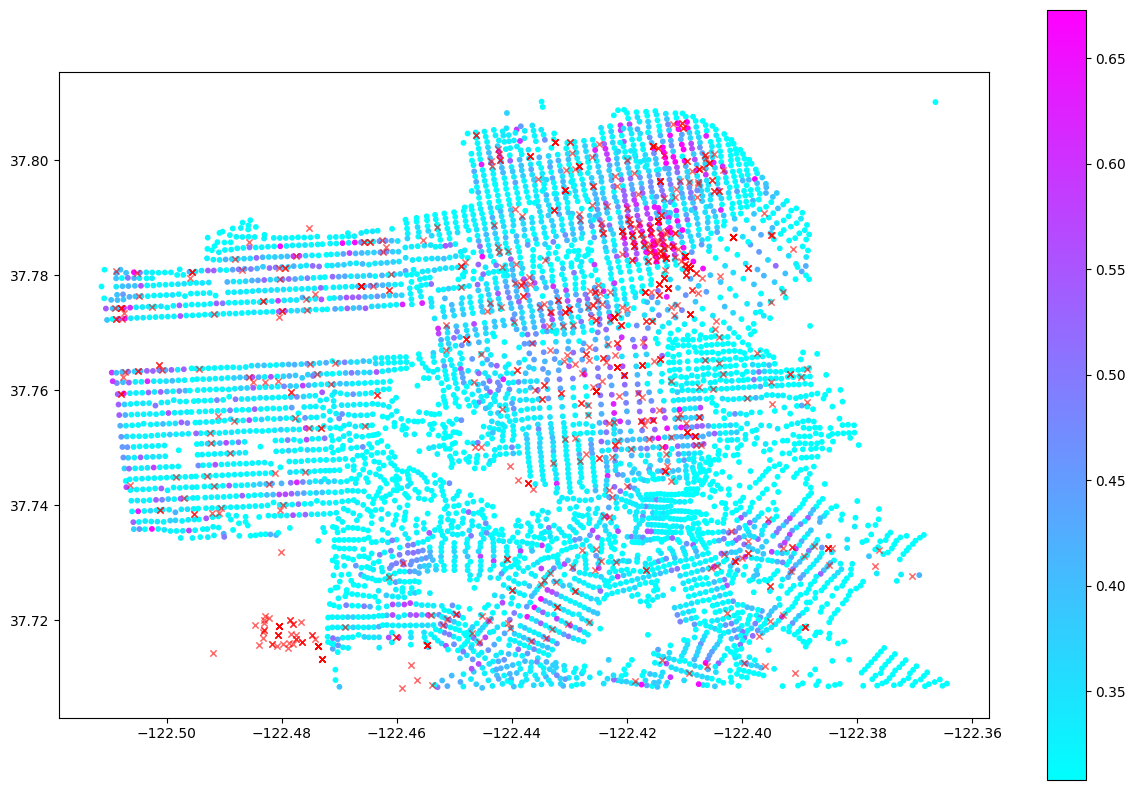

In [387]:
fig, ax = plt.subplots(figsize=(15, 10))
df_m.plot("y_pred", ax=ax, legend=True, markersize=10, cmap="cool")
df_e.loc[df_e["year"] == 2020].plot(ax=ax, alpha=0.2, color="red", markersize=20, marker="x", linewidths=1)
plt.show()

score                                     feature
8     1.0                               use_code_comr
21    1.0                               use_code_govt
23    3.0                                use_code_ind
45    5.0                     assessed_fixtures_value
38    5.0                               use_code_como
43    6.0                               use_code_comm
4     6.0                               property_area
27    6.0                               use_code_misc
25    7.0                     use_code_govt_neighbors
12    7.0                                      degree
44    9.0                                     cliques
46   10.0                         number_of_bathrooms
10   10.0                               use_code_comh
47   11.0                                  clustering
24   12.0                          number_of_bedrooms
26   13.0                      use_code_ind_neighbors
28   13.0                     use_code_comh_neighbors
39   14.0                   number_of_rooms_neighbors
13   15.0           assessed_fixtures_value_neighbors
37   15.0                   number_of_units_neighbors
33   15.0               number_of_bathrooms_neighbors
40   16.0                                   longitude
19   16.0                               use_code_sres
36   16.0                     use_code_mres_neighbors
5    17.0            assessed_personal_property_value
20   17.0                  assessed_improvement_value
42   20.0                             number_of_rooms
29   20.0                     use_code_como_neighbors
7    20.0                     use_code_comr_neighbors
22   21.0                     use_code_sres_neighbors
30   22.0                              eviction_count
0    23.0                         assessed_land_value
15   23.0        assessed_improvement_value_neighbors
16   24.0                                    latitude
6    25.0                     property_area_neighbors
14   25.0                      betweenness_centrality
34   27.0                               use_code_mres
32   28.0                                   page_rank
11   30.0  assessed_personal_property_value_neighbors
18   31.0               assessed_land_value_neighbors
2    31.0                number_of_bedrooms_neighbors
9    33.0                                  constraint
41   35.0                     use_code_misc_neighbors
1    38.0                     use_code_comm_neighbors
35   39.0                        closeness_centrality
3    39.0                            eigen_centrality
31   43.0                    eviction_count_neighbors
17   52.0                             number_of_units

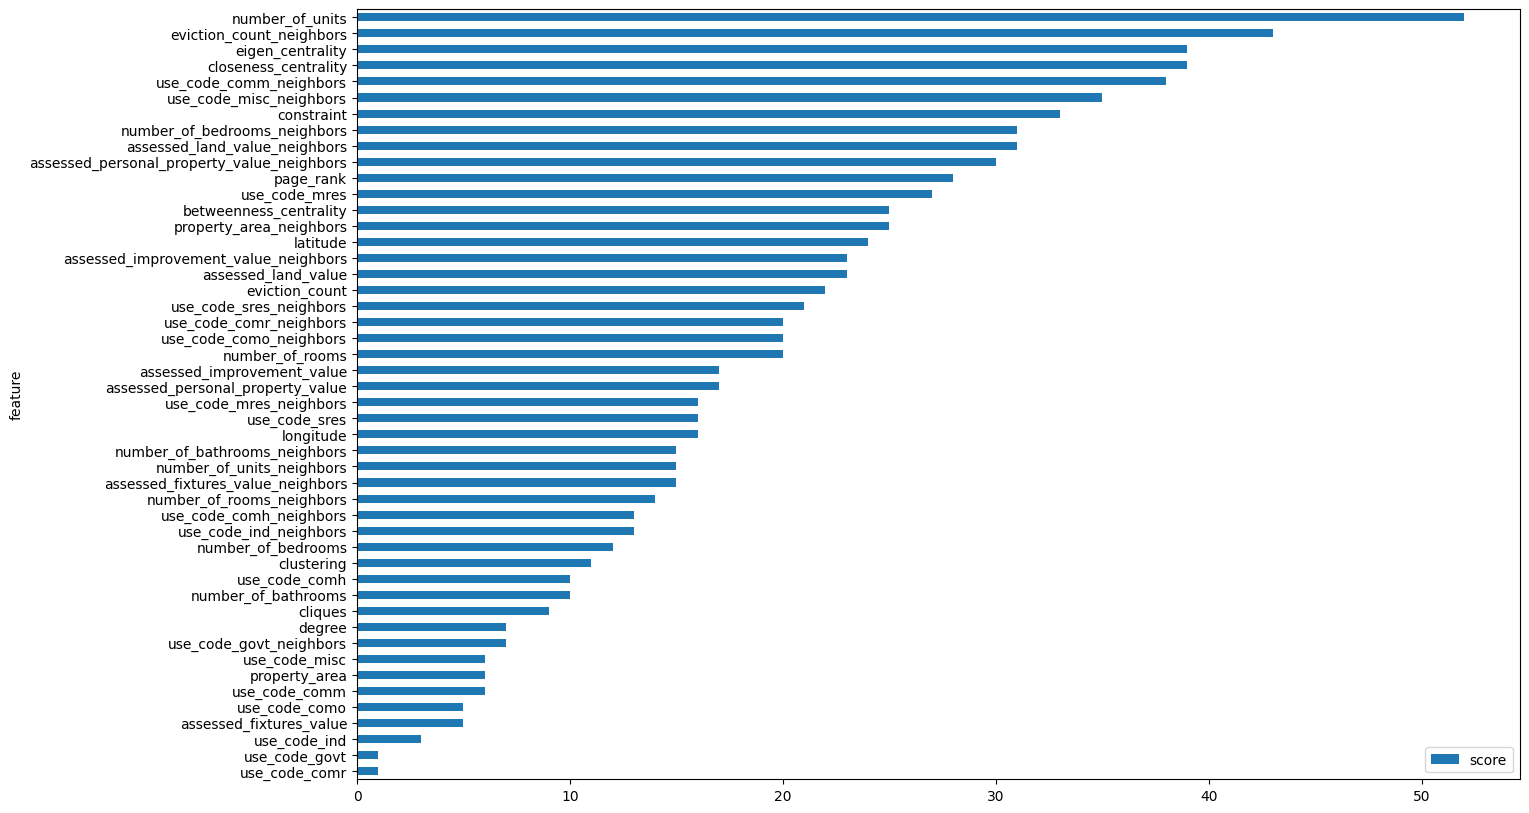

In [388]:
scores = model.get_score()
weights = model.get_score(importance_type="weight")
fi = pd.DataFrame([(scores[f"f{i}"], f) for i, f in enumerate(feature_sets["all"]) if f"f{i}" in scores], columns=["score", "feature"])
fi = fi.sort_values("score", ascending=True)
fi.plot.barh(figsize=(15, 10), x="feature", y="score")
fi

score                           feature
14    1.0                      use_code_ind
11    4.0                     use_code_como
13    6.0                     use_code_govt
15   11.0                     use_code_misc
9    13.0                     use_code_comh
2    15.0           assessed_fixtures_value
10   15.0                     use_code_comm
12   18.0                     use_code_comr
18   31.0                    eviction_count
17   45.0                     use_code_sres
8    51.0               number_of_bathrooms
16   52.0                     use_code_mres
0    54.0  assessed_personal_property_value
7    57.0                number_of_bedrooms
4    58.0                     property_area
6    66.0                   number_of_rooms
3    73.0        assessed_improvement_value
1    73.0               assessed_land_value
5    97.0                   number_of_units

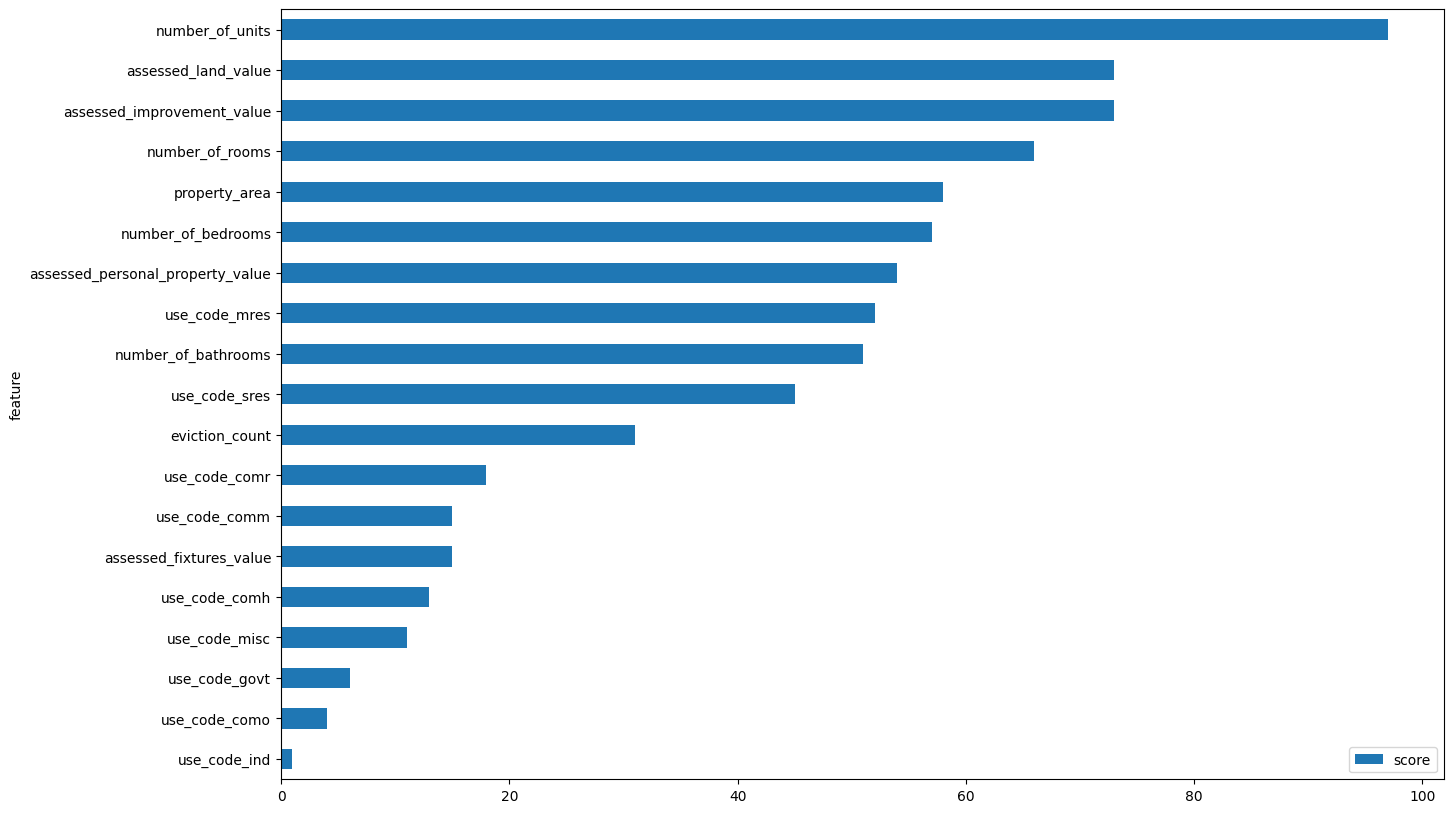

In [389]:
scores = model_tax.get_score()
weights = model_tax.get_score(importance_type="weight")
fi = pd.DataFrame([(scores[f"f{i}"], f) for i, f in enumerate(feature_sets["tax"]) if f"f{i}" in scores], columns=["score", "feature"])
fi = fi.sort_values("score", ascending=True)
fi.plot.barh(figsize=(15, 10), x="feature", y="score")
fi

score                                     feature
14   24.0                      use_code_ind_neighbors
4    30.0                     property_area_neighbors
15   31.0                     use_code_misc_neighbors
11   35.0                     use_code_como_neighbors
9    36.0                     use_code_comh_neighbors
6    37.0                   number_of_rooms_neighbors
5    41.0                   number_of_units_neighbors
13   41.0                     use_code_govt_neighbors
8    45.0               number_of_bathrooms_neighbors
7    52.0                number_of_bedrooms_neighbors
1    54.0               assessed_land_value_neighbors
16   55.0                     use_code_mres_neighbors
0    56.0  assessed_personal_property_value_neighbors
2    57.0           assessed_fixtures_value_neighbors
17   58.0                     use_code_sres_neighbors
3    65.0        assessed_improvement_value_neighbors
10   67.0                     use_code_comm_neighbors
12   72.0                     use_code_comr_neighbors
18   88.0                    eviction_count_neighbors

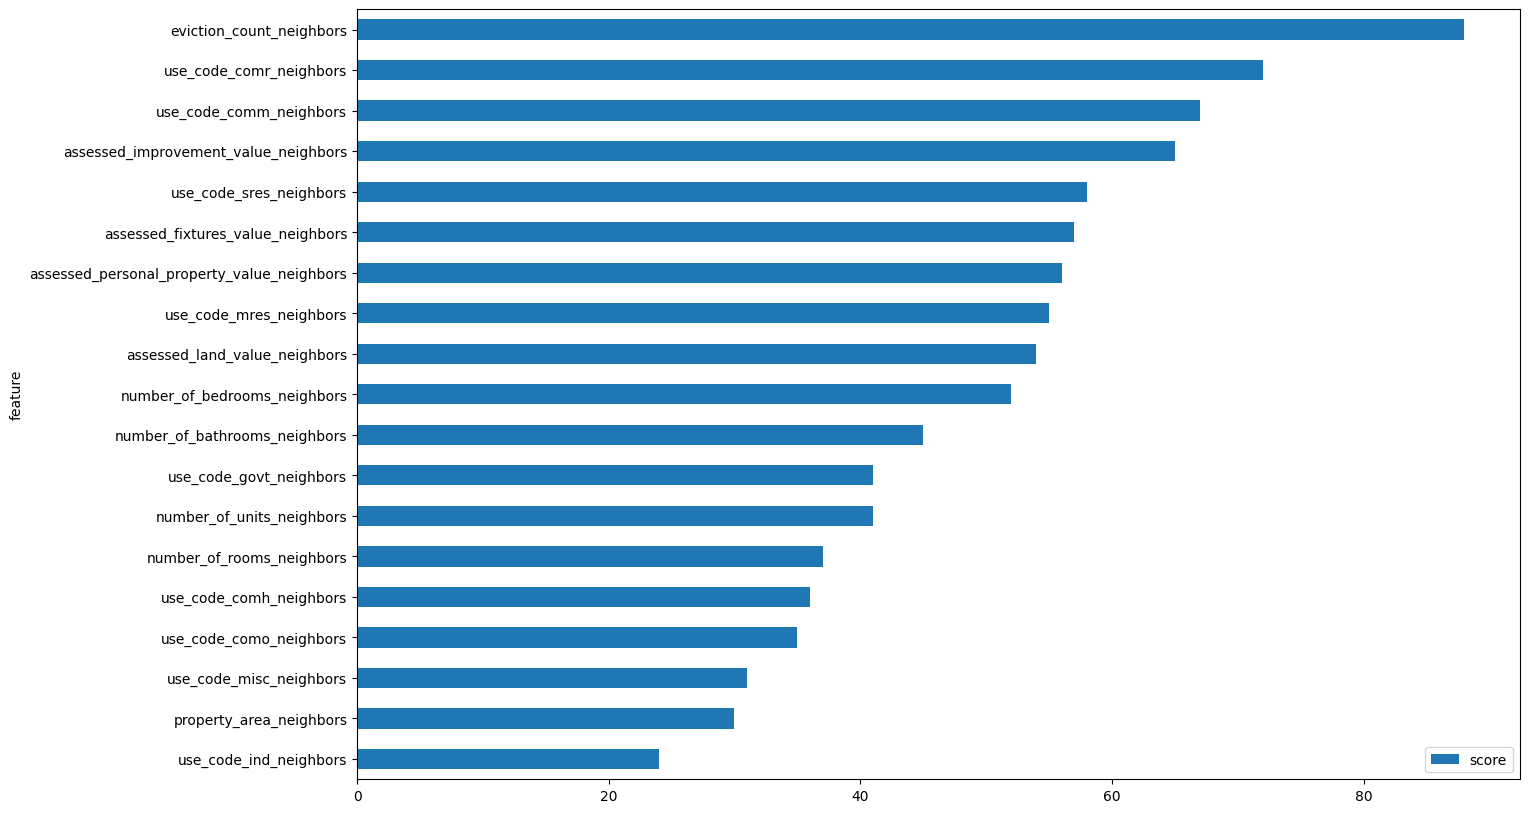

In [390]:
scores = model_neighbor.get_score()
weights = model_neighbor.get_score(importance_type="weight")
fi = pd.DataFrame([(scores[f"f{i}"], f) for i, f in enumerate(feature_sets["neighbor"]) if f"f{i}" in scores], columns=["score", "feature"])
fi = fi.sort_values("score", ascending=True)
fi.plot.barh(figsize=(15, 10), x="feature", y="score")
fi

score                 feature
0   17.0                  degree
6   21.0                 cliques
5   64.0               page_rank
2   65.0  betweenness_centrality
3   68.0    closeness_centrality
7   77.0              constraint
1   89.0              clustering
9  117.0                latitude
8  119.0               longitude
4  146.0        eigen_centrality

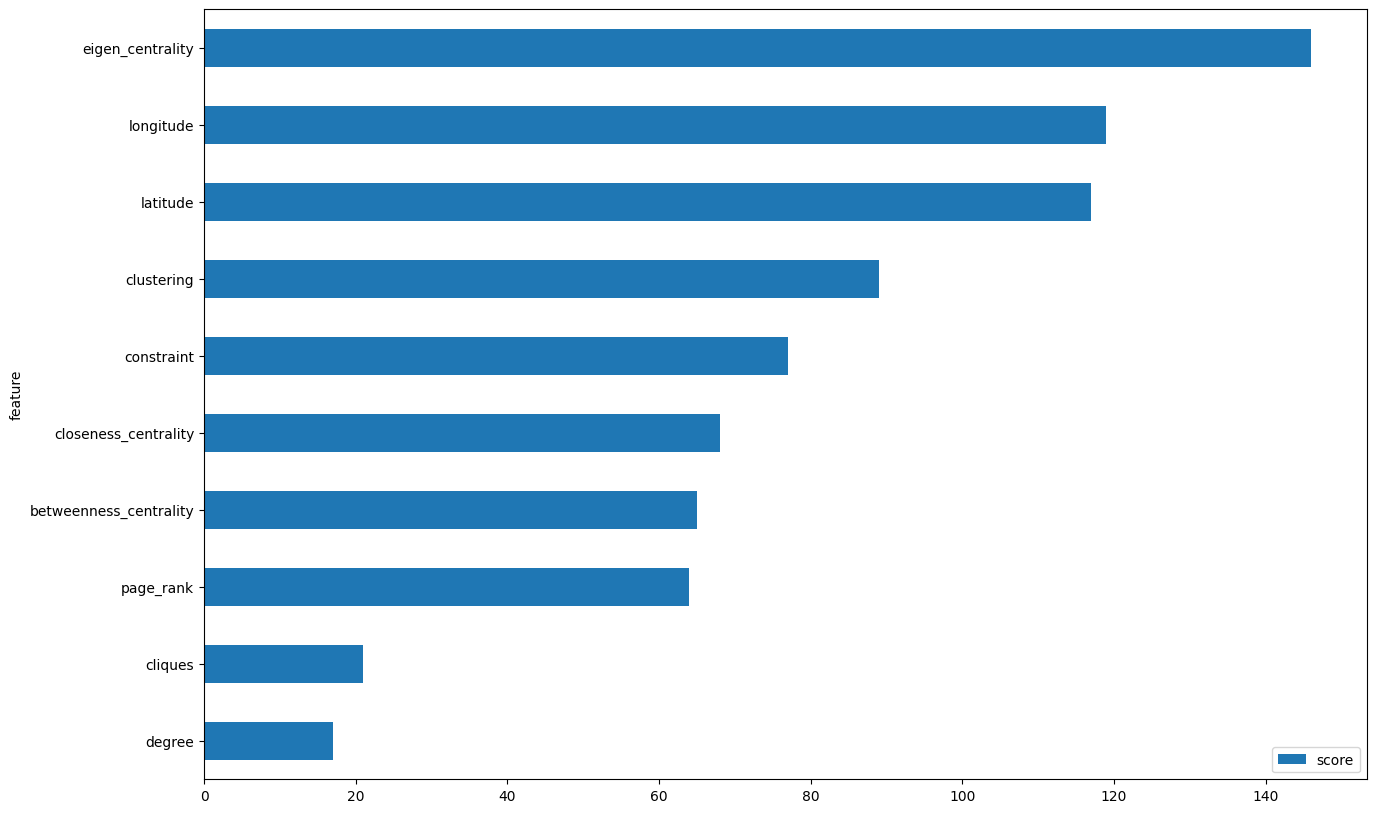

In [391]:
scores = model_graph.get_score()
weights = model_graph.get_score(importance_type="weight")
fi = pd.DataFrame([(scores[f"f{i}"], f) for i, f in enumerate(feature_sets["graph"]) if f"f{i}" in scores], columns=["score", "feature"])
fi = fi.sort_values("score", ascending=True)
fi.plot.barh(figsize=(15, 10), x="feature", y="score")
fi

### Qualitative Analysis

In [392]:
df_2018 = df.loc[df["year"] == 2018]
df_a = df_b.merge(df_2019, on=["block"], how="left")
df_a

block                     geometry    year  \
0     0001  POINT (-122.42156 37.80866)  2019.0   
1     0002  POINT (-122.42050 37.80873)  2019.0   
2     0004  POINT (-122.41508 37.80851)  2019.0   
3     0005  POINT (-122.41668 37.80840)  2019.0   
4     0006  POINT (-122.41835 37.80832)  2019.0   
...    ...                          ...     ...   
5397  8952  POINT (-122.36696 37.80978)  2019.0   
5398  8953  POINT (-122.36639 37.81007)  2019.0   
5399  8954  POINT (-122.36544 37.81144)  2019.0   
5400  8958  POINT (-122.36838 37.81103)  2019.0   
5401  9900  POINT (-122.39584 37.79294)     NaN   

      assessed_personal_property_value  assessed_land_value  \
0                                  0.0                  0.0   
1                                  0.0                  0.0   
2                                  0.0                  0.0   
3                                  0.0                  0.0   
4                                  0.0                  0.0   
...                                ...                  ...   
5397                               0.0           13134600.0   
5398                               0.0                  0.0   
5399                               0.0            3090982.5   
5400                               0.0                  0.0   
5401                               NaN                  NaN   

      assessed_fixtures_value  assessed_improvement_value  property_area  \
0                         0.0                    702032.0            0.0   
1                         0.0                         0.0            0.0   
2                         0.0                         0.0            0.0   
3                         0.0                         0.0            0.0   
4                         0.0                         0.0            0.0   
...                       ...                         ...            ...   
5397                      0.0                         0.0            0.0   
5398                      0.0                         0.0            0.0   
5399                      0.0                         0.0            0.0   
5400                      0.0                         0.0            0.0   
5401                      NaN                         NaN            NaN   

      number_of_units  number_of_rooms  ...  clustering  \
0                 0.0              0.0  ...    0.800000   
1                 0.0              0.0  ...    0.844444   
2                 0.0              0.0  ...    0.743590   
3                 0.0              0.0  ...    0.670330   
4                 0.0              0.0  ...    0.681319   
...               ...              ...  ...         ...   
5397              0.0              0.0  ...    0.733333   
5398              0.0              0.0  ...    0.800000   
5399              0.0              0.0  ...    1.000000   
5400              0.0              0.0  ...    0.619048   
5401              NaN              NaN  ...         NaN   

      betweenness_centrality  closeness_centrality  eigen_centrality  \
0               1.791900e-06              0.043991      3.264575e-07   
1               2.492843e-07              0.044009      3.291674e-07   
2               1.340645e-05              0.043313      3.035517e-07   
3               1.441052e-05              0.043642      3.794351e-07   
4               9.709285e-06              0.043866      4.464551e-07   
...                      ...                   ...               ...   
5397            9.714708e-08              0.001134      8.721721e-24   
5398            4.571627e-08              0.001008      7.524343e-24   
5399            0.000000e+00              0.000825      4.871874e-24   
5400            2.457250e-07              0.001296      9.497001e-24   
5401                     NaN                   NaN               NaN   

      page_rank  bridge  cliques  constraint   latitude   longitude  
0      0.000108     0.0      8.0    0.205829  37.808658 -122.421557  
1      0

<AxesSubplot:>

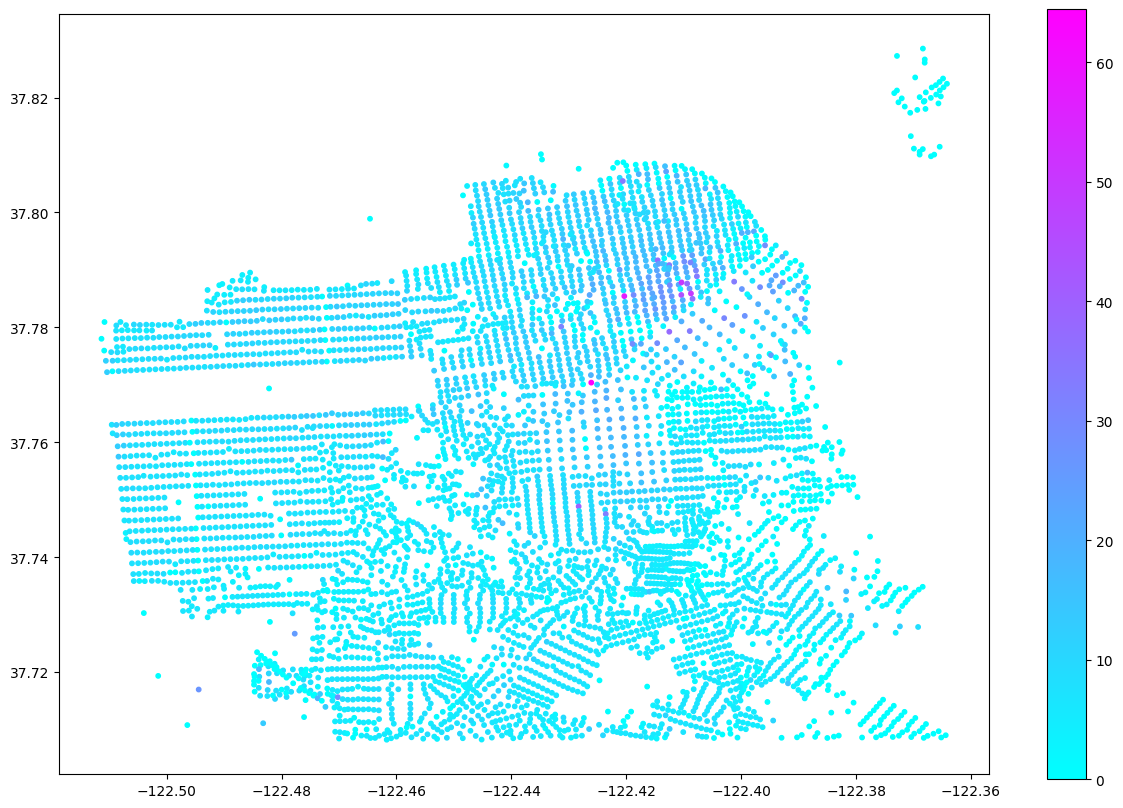

In [413]:
df_a["number_of_units_sqrt"] = df_a["number_of_units"].apply(lambda x: np.sqrt(x))
df_a.plot("number_of_units_sqrt", figsize=(15, 10), markersize=10, cmap="cool", legend=True)

<AxesSubplot:>

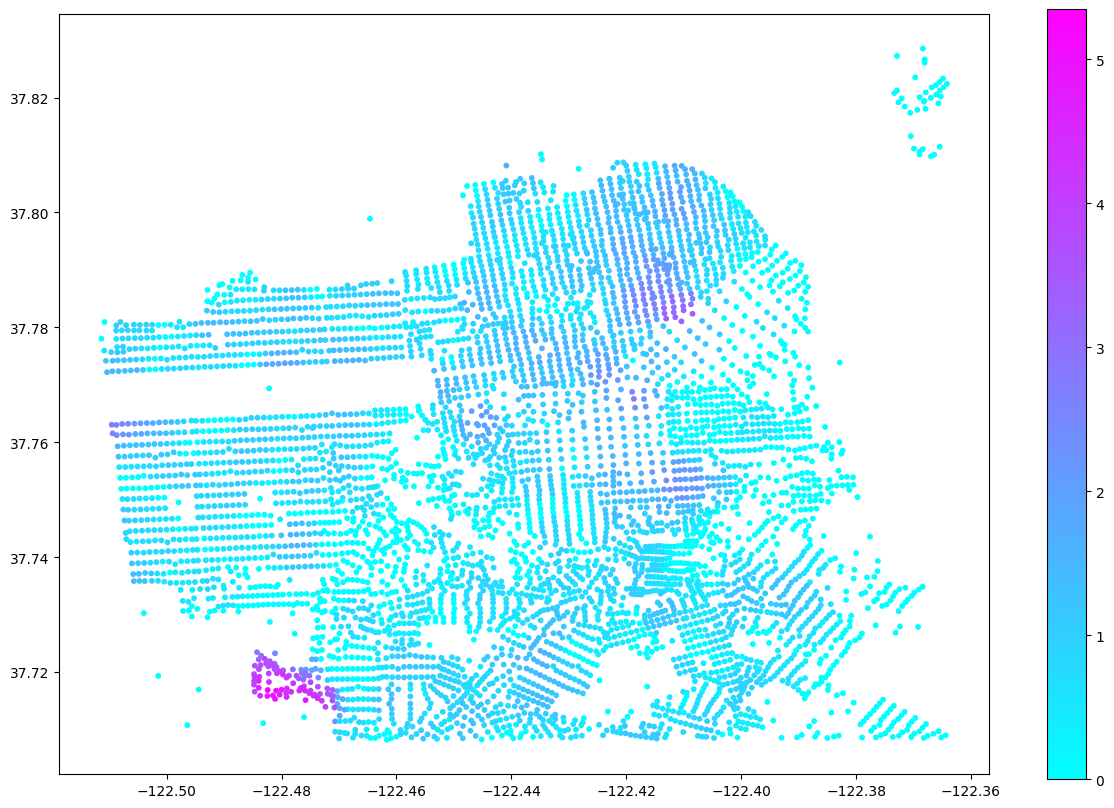

In [414]:
df_a["eviction_count_neighbors_sqrt"] = df_a["eviction_count_neighbors"].apply(lambda x: np.sqrt(x))
df_a.plot("eviction_count_neighbors_sqrt", figsize=(15, 10), markersize=10, cmap="cool", legend=True)

<AxesSubplot:>

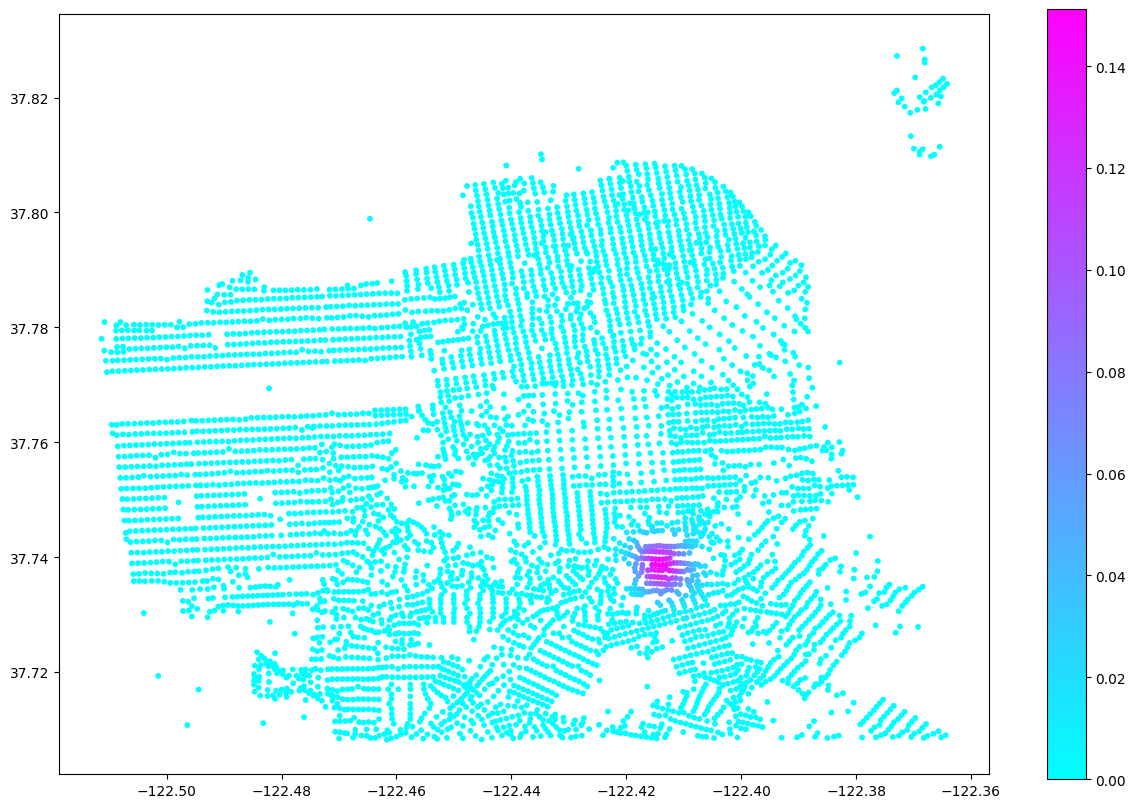

In [416]:
df_a["eigen_centrality_sqrt"] = df_a["eigen_centrality"].apply(lambda x: np.sqrt(x))
df_a.plot("eigen_centrality", figsize=(15, 10), markersize=10, cmap="cool", legend=True)

<AxesSubplot:>

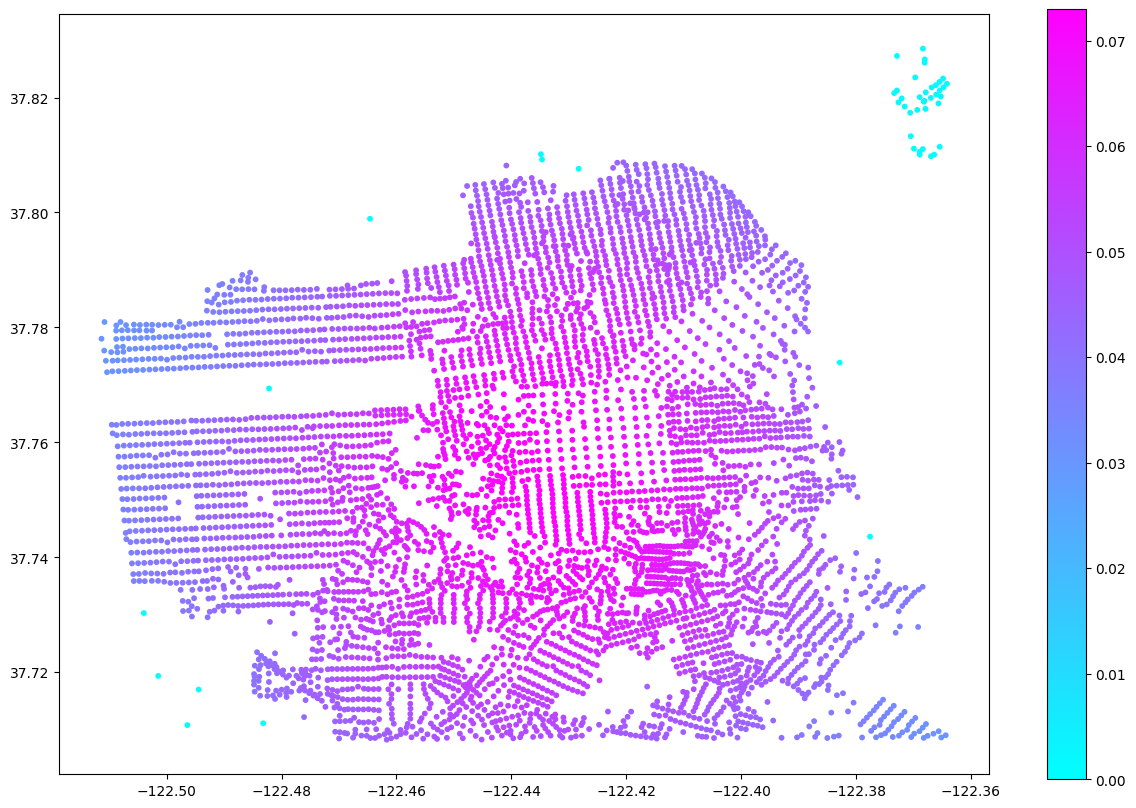

In [420]:
df_a.plot("closeness_centrality", figsize=(15, 10), markersize=10, cmap="cool", legend=True)

<AxesSubplot:>

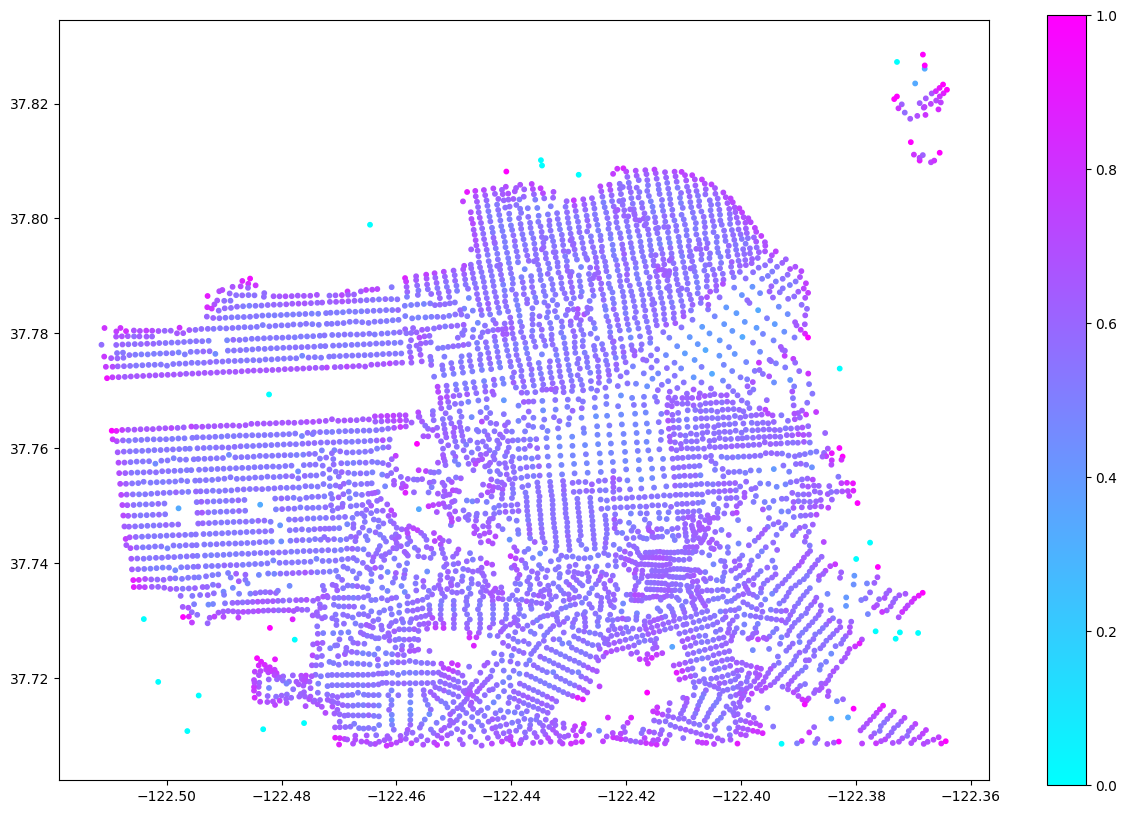

In [417]:
df_a.plot("clustering", figsize=(15, 10), markersize=10, cmap="cool", legend=True)

<AxesSubplot:>

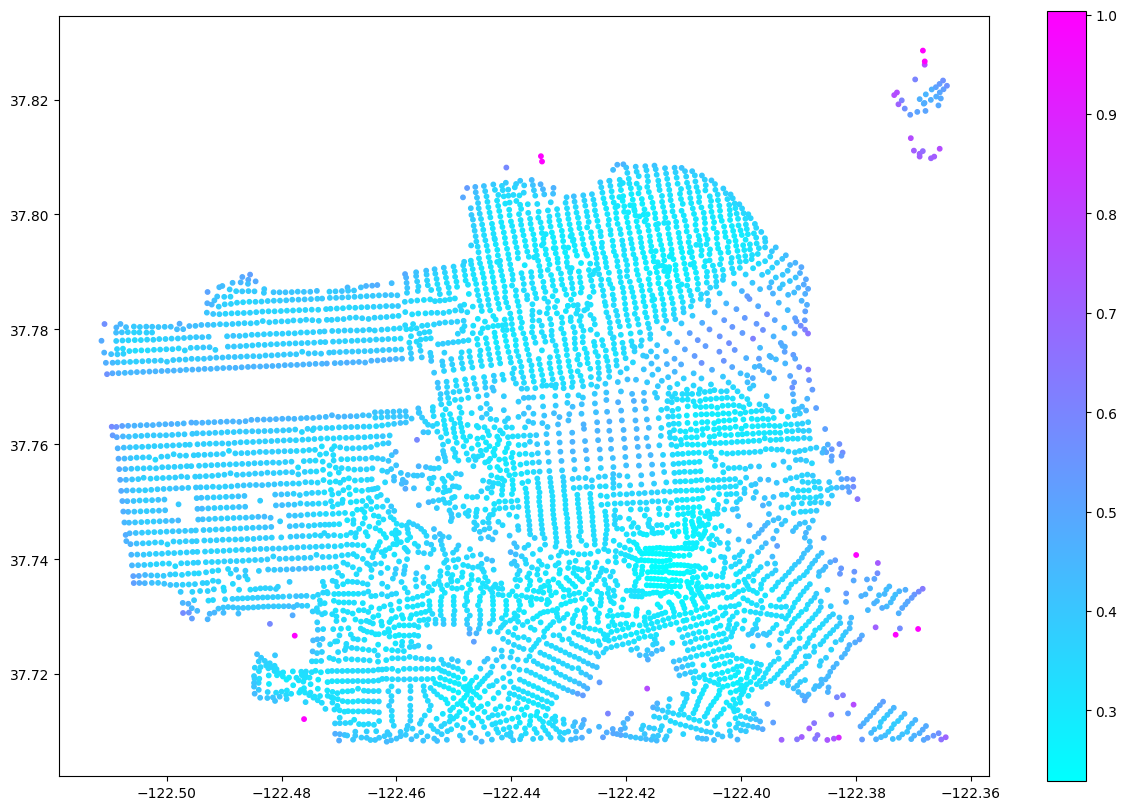

In [422]:
df_a["constraint_squared"] = df_a["constraint"].apply(lambda x: x **0.5)
df_a.plot("constraint_squared", figsize=(15, 10), markersize=10, cmap="cool", legend=True)

<AxesSubplot:>

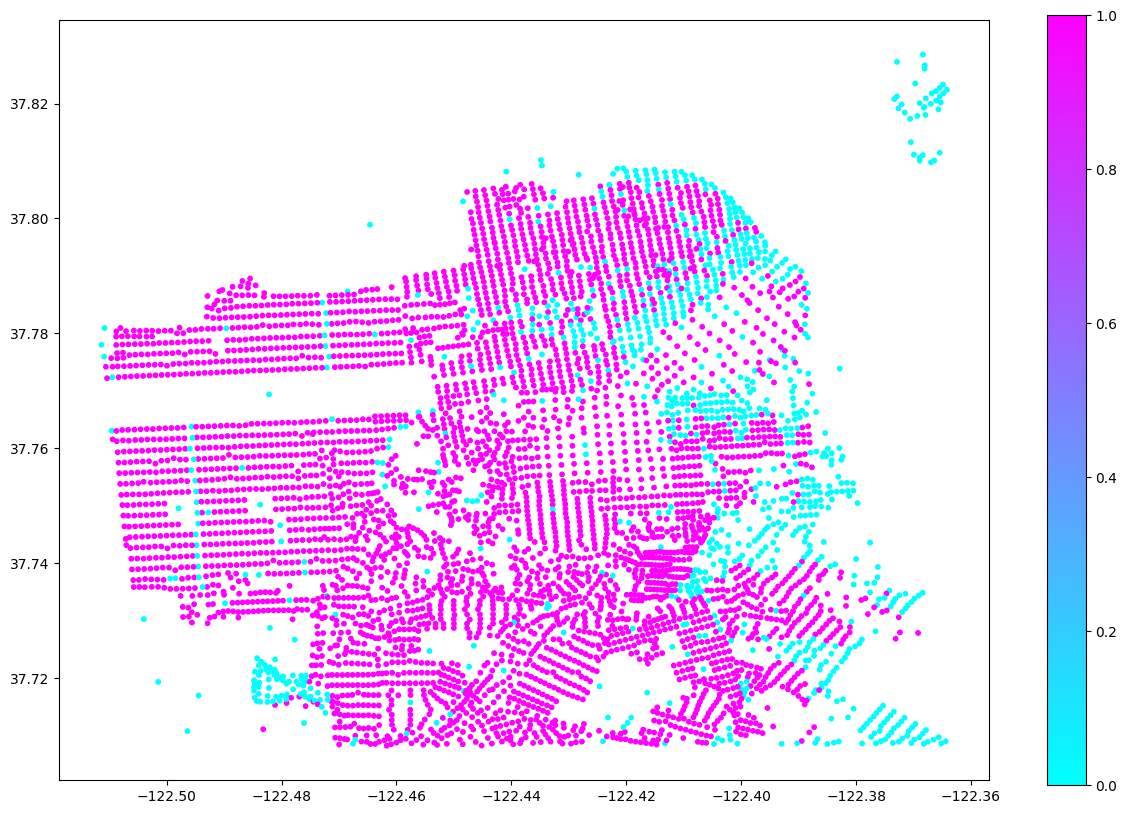

In [404]:
df_a["use_code_sres_b"] = df_a["use_code_sres"].apply(lambda x: 1 if x > 0 else 0)
df_a.plot("use_code_sres_b", figsize=(15, 10), markersize=10, cmap="cool", legend=True)

<AxesSubplot:>

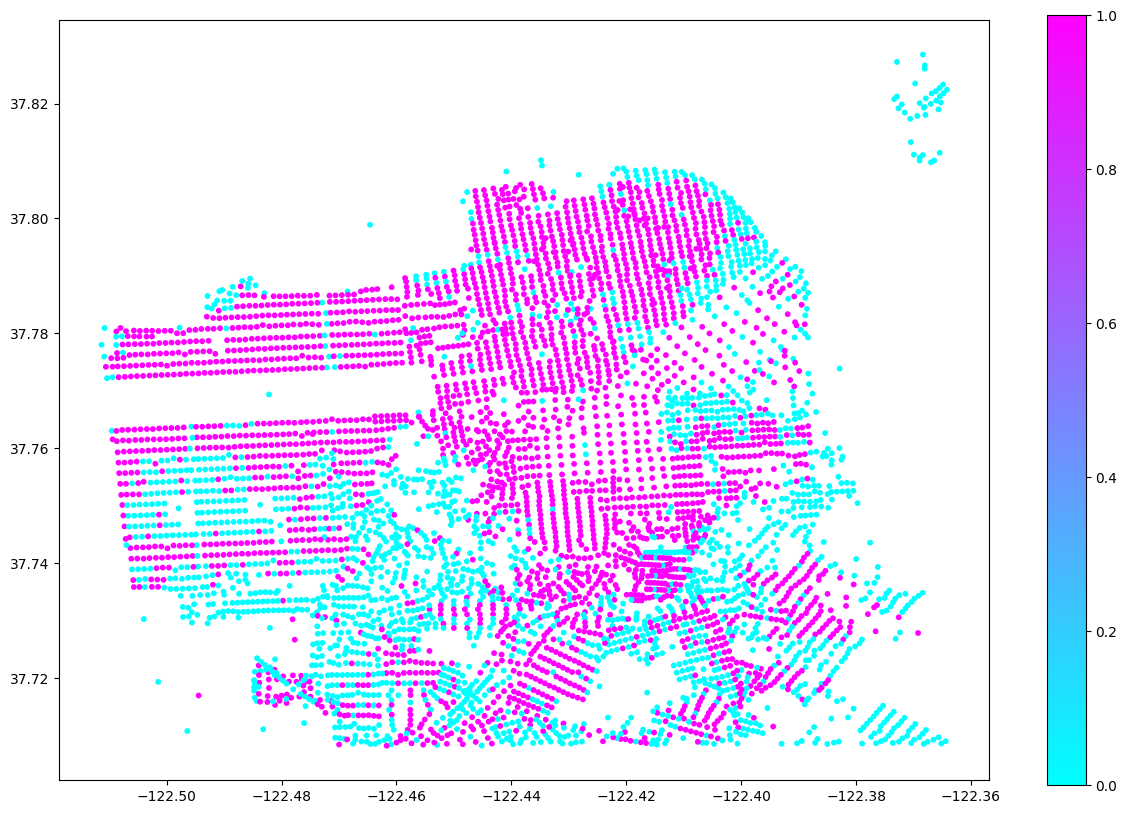

In [405]:
df_a["use_code_mres_b"] = df_a["use_code_mres"].apply(lambda x: 1 if x > 0 else 0)
df_a.plot("use_code_mres_b", figsize=(15, 10), markersize=10, cmap="cool", legend=True)